In [47]:
import os

import pandas as pd
from IPython.display import display

pd.options.display.float_format = '{:.2f}'.format
import warnings
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import *
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings("ignore")

In [48]:
file_paths = [f"error/hirasaki_{i}_errors.csv" for i in range(10)]
dataframes = [pd.read_csv(file_path, index_col=0) for file_path in file_paths]

In [49]:
frame_wise_avg_mpjpe_combinations_revised = {n: [] for n in range(2, 6)}

for n in range(5):
    for combo_indices in combinations(range(5), n + 2):
        for df in dataframes:
            combo_col_name = f"{''.join(map(str, combo_indices))}_mpjpe"
            if combo_col_name in df.columns:
                frame_wise_avg_mpjpe_combinations_revised[n + 2].extend(df[combo_col_name].values)

print("Number of combinations for each n:")
for n, values in frame_wise_avg_mpjpe_combinations_revised.items():
    print(f"n={n}: {len(values)}")

Number of combinations for each n:
n=2: 18440
n=3: 18440
n=4: 9220
n=5: 1844


In [50]:
raw_combination_data = []
for df in dataframes:
    for col in df.columns:
        if "_mpjpe" in col or "_angle" in col:
            error_type = "MPJPE" if "_mpjpe" in col else col.split('_')[1] + " " + col.split('_')[2]
            if len(col.split('_')) == 6:
                error_type += " " + col.split('_')[3]
            error_type = error_type.replace("NKEE", "KNEE")
            for value in df[col].values:
                raw_combination_data.append({"Combination": col.split('_')[0], "Error Type": error_type, "Error Value": value})

raw_combination_df = pd.DataFrame(raw_combination_data)
raw_combination_df.head()

,Combination,Error Type,Error Value
0,01,MPJPE,31.56
1,01,MPJPE,32.11
2,01,MPJPE,35.39
3,01,MPJPE,33.97
4,01,MPJPE,30.75


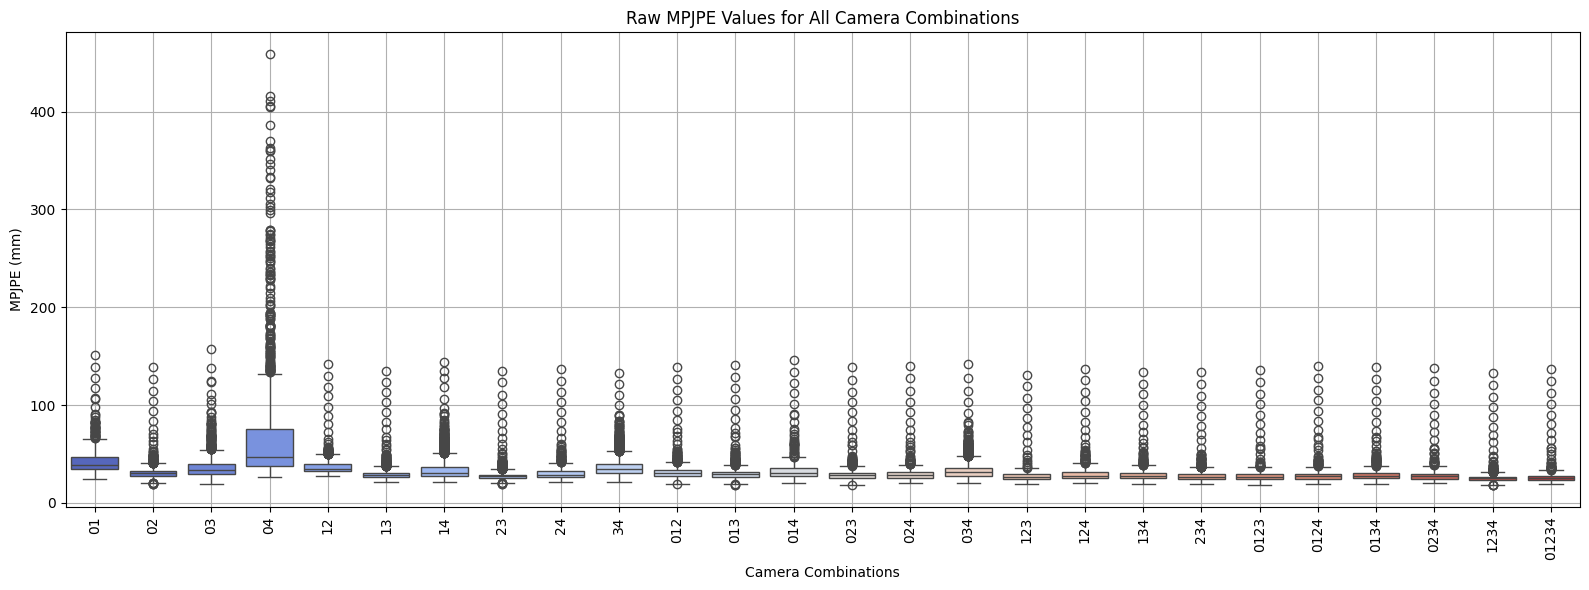

In [51]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=raw_combination_df[raw_combination_df["Error Type"] == "MPJPE"], x="Combination", y="Error Value", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Raw MPJPE Values for All Camera Combinations")
plt.xlabel("Camera Combinations")
plt.ylabel("MPJPE (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

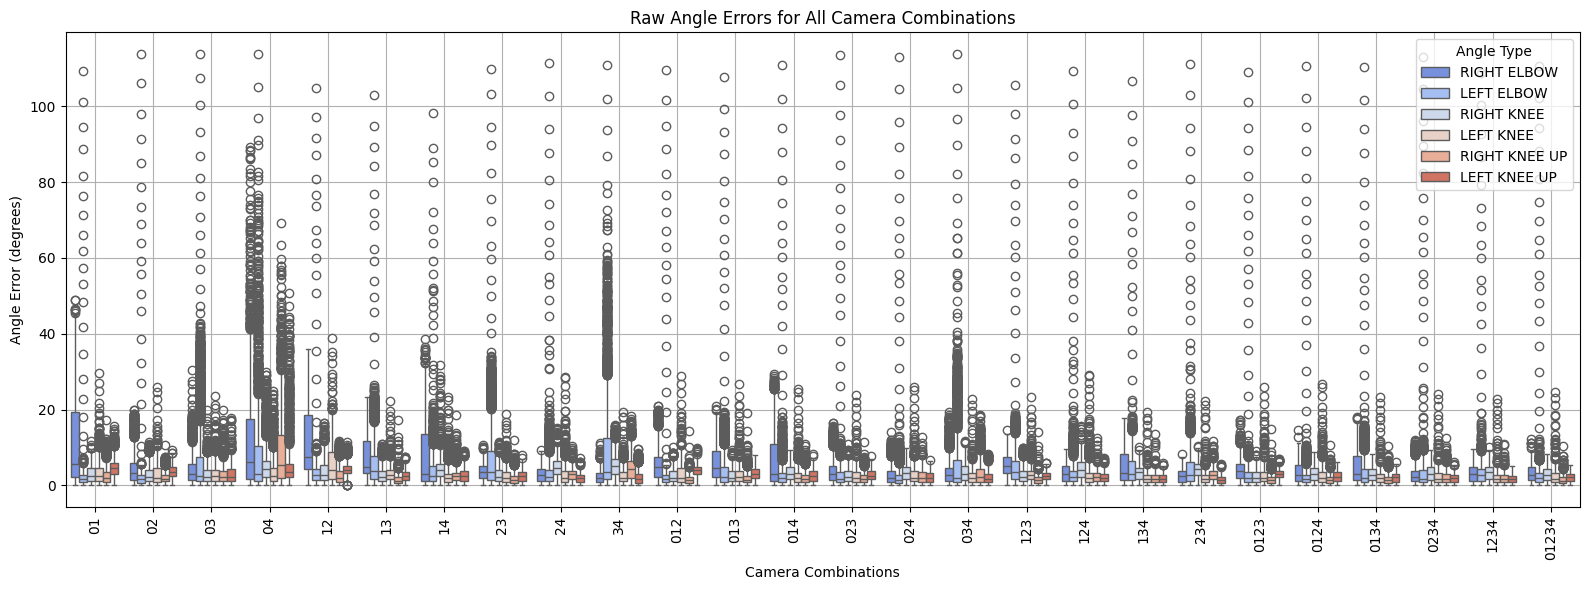

In [52]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=raw_combination_df[raw_combination_df["Error Type"] != "MPJPE"], x="Combination", y="Error Value", hue="Error Type", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Raw Angle Errors for All Camera Combinations")
plt.xlabel("Camera Combinations")
plt.ylabel("Angle Error (degrees)")
plt.legend(title="Angle Type")
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [54]:
mpjpe_df = raw_combination_df[raw_combination_df["Error Type"] == "MPJPE"]
mpjpe_df_no_outliers = remove_outliers(mpjpe_df, "Error Value")

angle_error_df = raw_combination_df[raw_combination_df["Error Type"] != "MPJPE"]
angle_error_df_no_outliers = remove_outliers(angle_error_df, "Error Value")

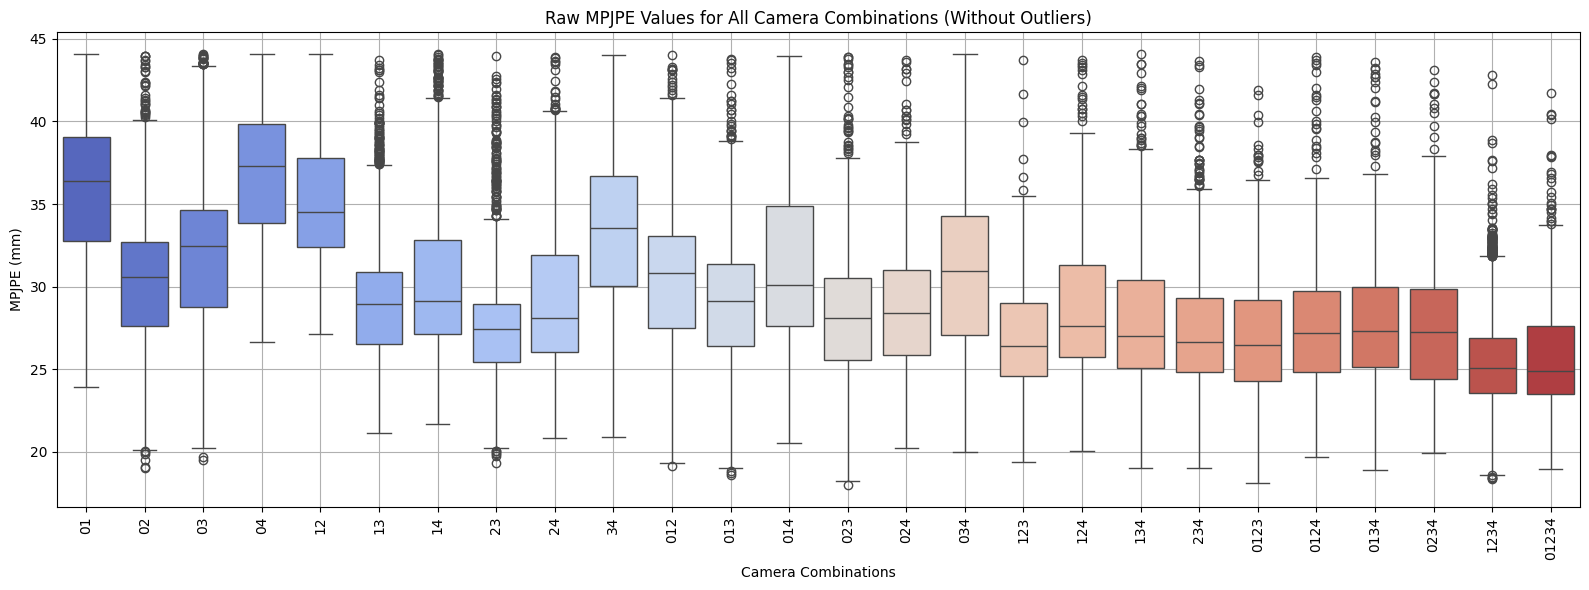

In [55]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=mpjpe_df_no_outliers, x="Combination", y="Error Value", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Raw MPJPE Values for All Camera Combinations (Without Outliers)")
plt.xlabel("Camera Combinations")
plt.ylabel("MPJPE (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

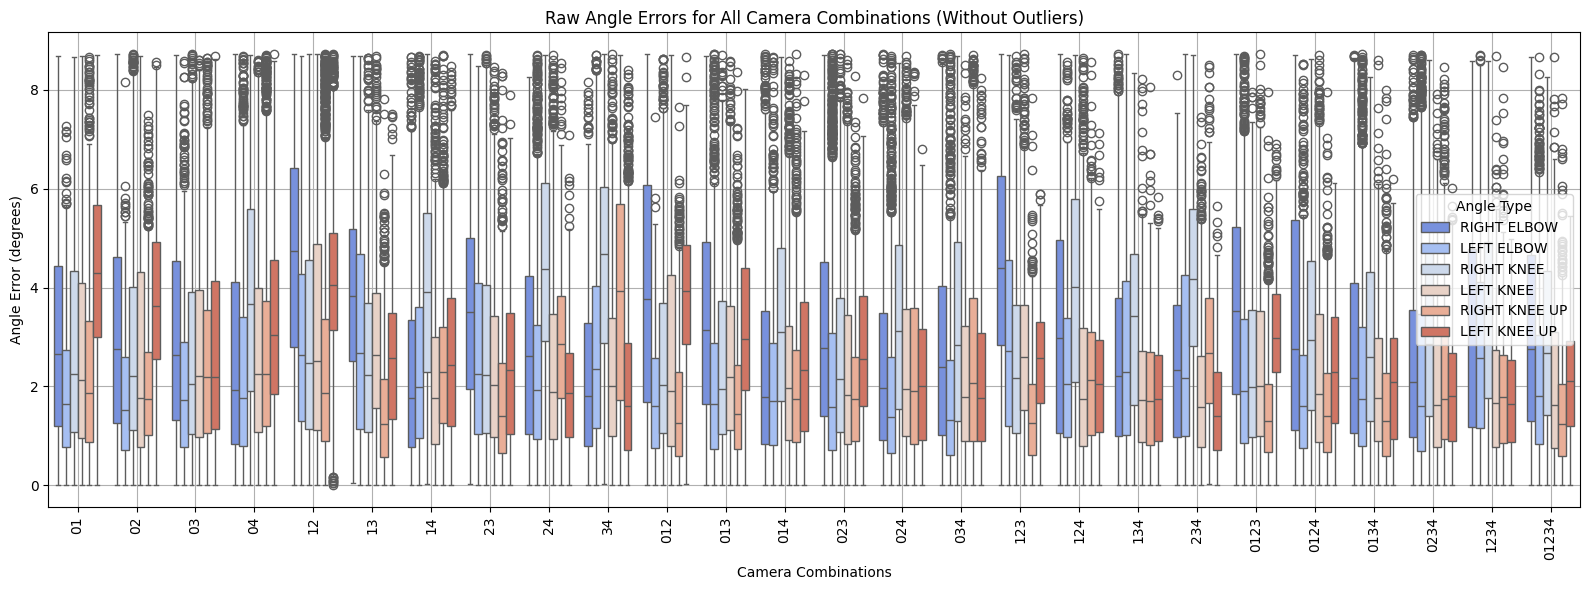

In [56]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=angle_error_df_no_outliers, x="Combination", y="Error Value", hue="Error Type", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Raw Angle Errors for All Camera Combinations (Without Outliers)")
plt.xlabel("Camera Combinations")
plt.ylabel("Angle Error (degrees)")
plt.legend(title="Angle Type")
plt.grid(True)
plt.tight_layout()
plt.show()

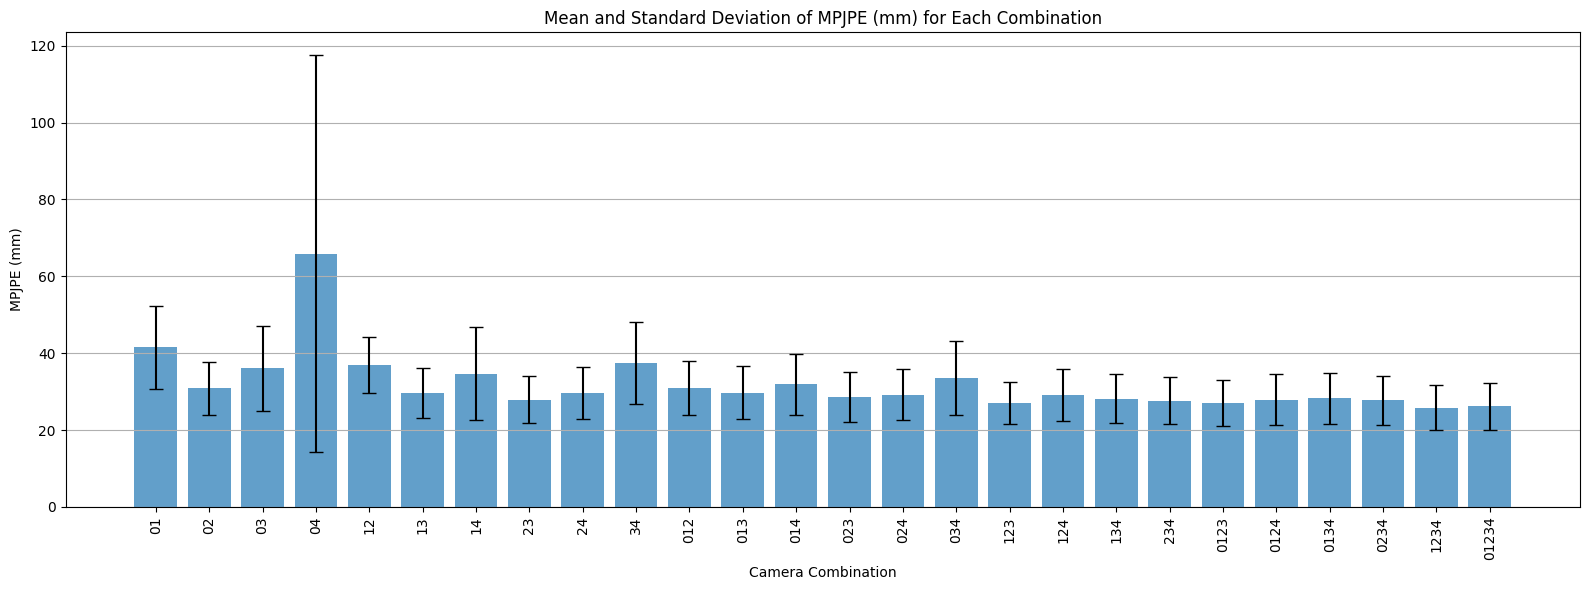

In [57]:
combination_order = raw_combination_df["Combination"].unique()

mean_values = raw_combination_df[raw_combination_df["Error Type"] == "MPJPE"].groupby("Combination")["Error Value"].mean().reindex(combination_order)
std_values = raw_combination_df[raw_combination_df["Error Type"] == "MPJPE"].groupby("Combination")["Error Value"].std().reindex(combination_order)

plt.figure(figsize=(16, 6))
plt.bar(mean_values.index, mean_values, yerr=std_values, capsize=5, alpha=0.7)
plt.xticks(rotation=90)
plt.title("Mean and Standard Deviation of MPJPE (mm) for Each Combination")
plt.xlabel("Camera Combination")
plt.ylabel("MPJPE (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

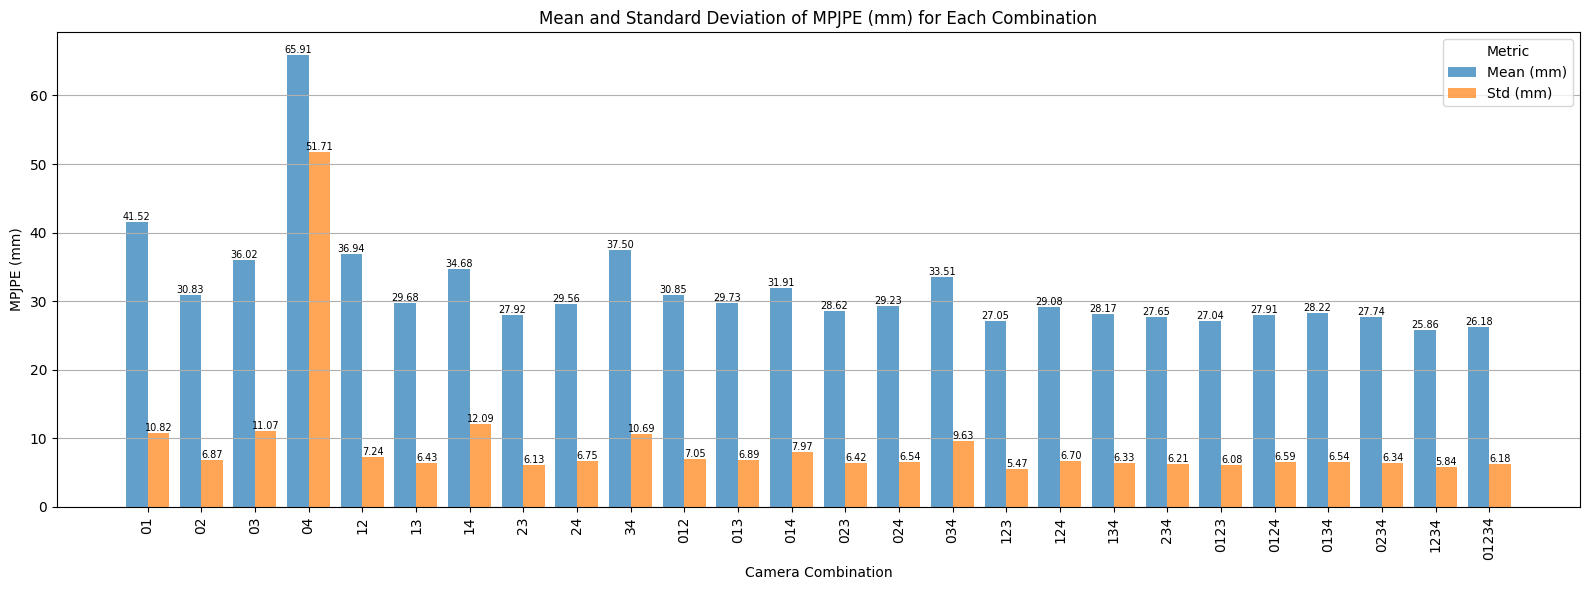

In [58]:
x = range(len(mean_values))
bar_width = 0.4

plt.figure(figsize=(16, 6))
mean_bars = plt.bar(x, mean_values, width=bar_width, label='Mean (mm)', alpha=0.7)
std_bars = plt.bar([p + bar_width for p in x], std_values, width=bar_width, label='Std (mm)', alpha=0.7)

for bar, mean in zip(mean_bars, mean_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mean:.2f}', ha='center', va='bottom', fontsize=7, color='black')
for bar, std in zip(std_bars, std_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{std:.2f}', ha='center', va='bottom', fontsize=7, color='black')

plt.xticks([p + bar_width / 2 for p in x], mean_values.index, rotation=90)
plt.title("Mean and Standard Deviation of MPJPE (mm) for Each Combination")
plt.xlabel("Camera Combination")
plt.ylabel("MPJPE (mm)")
plt.legend(title="Metric")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [59]:
camera04_two_camera_data = raw_combination_df[
    (raw_combination_df["Error Type"] == "MPJPE") &
    (raw_combination_df["Combination"].str.len() == 2) &
    (raw_combination_df["Combination"].str.contains("04"))
]["Error Value"]

other_two_camera_data = raw_combination_df[
    (raw_combination_df["Error Type"] == "MPJPE") &
    (raw_combination_df["Combination"].str.len() == 2) &
    (~raw_combination_df["Combination"].str.contains("04"))
]["Error Value"]

ks_stat_two_camera, ks_pvalue_two_camera = ks_2samp(camera04_two_camera_data, other_two_camera_data)
print(f"Two Camera Combination (04 vs Others):")
print(f"KS Statistic: {ks_stat_two_camera:.4f}, p-value: {ks_pvalue_two_camera:.4f}")

Two Camera Combination (04 vs Others):
KS Statistic: 0.5493, p-value: 0.0000


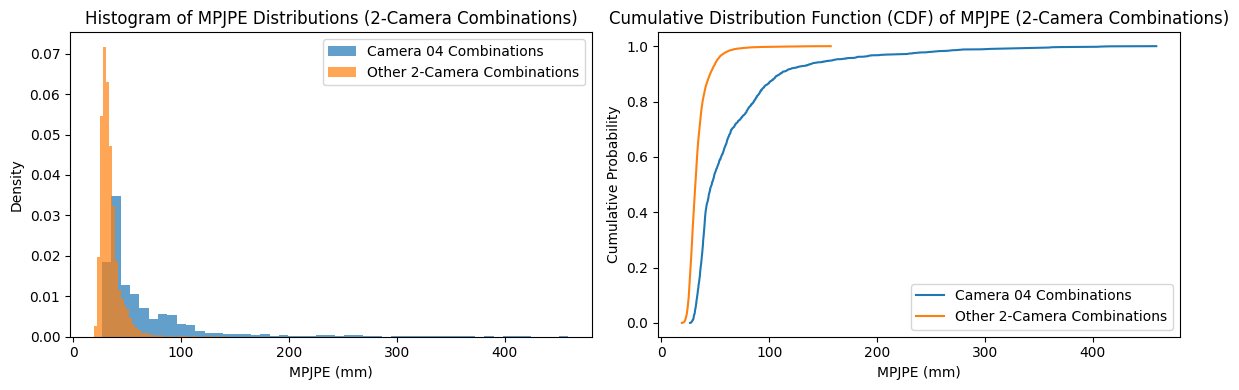

In [60]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(camera04_two_camera_data, bins=50, alpha=0.7, label="Camera 04 Combinations", density=True)
plt.hist(other_two_camera_data, bins=50, alpha=0.7, label="Other 2-Camera Combinations", density=True)
plt.title("Histogram of MPJPE Distributions (2-Camera Combinations)")
plt.xlabel("MPJPE (mm)")
plt.ylabel("Density")
plt.legend()

plt.subplot(1, 2, 2)
camera04_sorted = sorted(camera04_two_camera_data)
other_sorted = sorted(other_two_camera_data)
plt.plot(camera04_sorted, np.linspace(0, 1, len(camera04_sorted)), label="Camera 04 Combinations")
plt.plot(other_sorted, np.linspace(0, 1, len(other_sorted)), label="Other 2-Camera Combinations")
plt.title("Cumulative Distribution Function (CDF) of MPJPE (2-Camera Combinations)")
plt.xlabel("MPJPE (mm)")
plt.ylabel("Cumulative Probability")
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
stat_df = pd.DataFrame()
stat_df['Camera 04'] = camera04_two_camera_data.describe()
stat_df['Others'] = other_two_camera_data.describe()
display(stat_df)

,Camera 04,Others
count,1844.00,16596.00
mean,65.91,33.85
std,51.71,9.95
min,26.66,19.04
25%,37.82,27.85
50%,46.76,31.52
75%,75.99,36.55
max,458.91,157.03


In [62]:
mpjpe_df = raw_combination_df[(raw_combination_df["Error Type"] == "MPJPE") & (raw_combination_df["Combination"] != "04")]
display(mpjpe_df)

,Combination,Error Type,Error Value
0,01,MPJPE,31.56
1,01,MPJPE,32.11
2,01,MPJPE,35.39
3,01,MPJPE,33.97
4,01,MPJPE,30.75
...,...,...,...
334439,01234,MPJPE,34.52
334440,01234,MPJPE,36.56
334441,01234,MPJPE,40.43
334442,01234,MPJPE,41.69


In [63]:
mean_values = [mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"].mean() for n in range(2, 6)]
std_values = [mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"].std() for n in range(2, 6)]

print("Mean values for each n:")
for n, mean, std in zip(range(2, 6), mean_values, std_values):
    print(f"n={n}: {mean:.2f} ± {std:.2f}")

reduction_rates = [(mean_values[n] - mean_values[n + 1]) / mean_values[n] * 100 for n in range(3)]
print(f"Decreasing rates for each n:")
for n, rate in enumerate(reduction_rates):
    print(f"{n + 2} -> {n + 3}: {rate:.2f}")

diminishing_rates = [reduction_rates[n] - reduction_rates[n + 1] for n in range(2)]
print(f"Diminishing rates for each n:")
for n, rate in enumerate(diminishing_rates):
    print(f"{n + 2} -> {n + 3} -> {n + 4}: {rate:.2f}")

Mean values for each n:
n=2: 33.85 ± 9.95
n=3: 29.58 ± 7.26
n=4: 27.35 ± 6.34
n=5: 26.18 ± 6.18
Decreasing rates for each n:
2 -> 3: 12.61
3 -> 4: 7.53
4 -> 5: 4.30
Diminishing rates for each n:
2 -> 3 -> 4: 5.09
3 -> 4 -> 5: 3.22


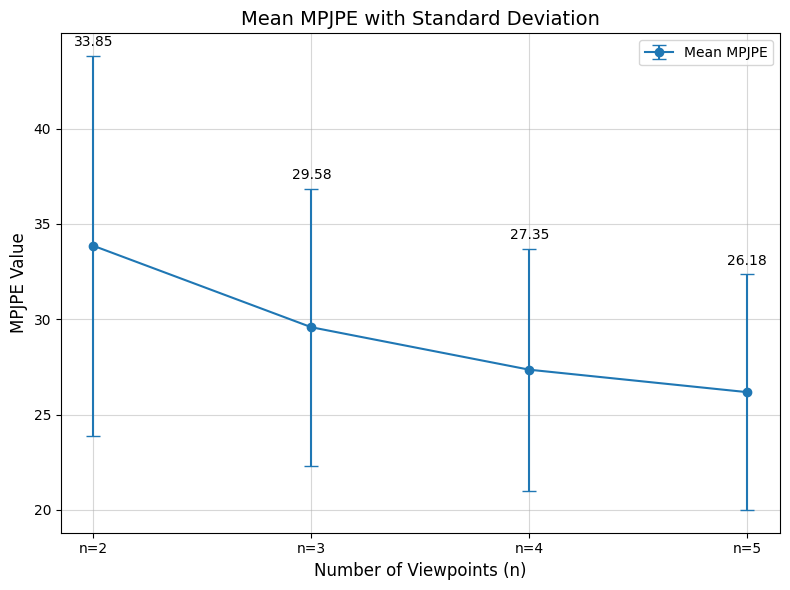

In [64]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(2, 6), mean_values, yerr=std_values, fmt='o-', capsize=5, label="Mean MPJPE")
for i, (x, y, std) in enumerate(zip(range(2, 6), mean_values, std_values)):
    plt.text(x, y + std + 0.5, f"{y:.2f}", ha='center', fontsize=10)
plt.title("Mean MPJPE with Standard Deviation", fontsize=14)
plt.xlabel("Number of Viewpoints (n)", fontsize=12)
plt.ylabel("MPJPE Value", fontsize=12)
plt.xticks(range(2, 6), labels=[f"n={n}" for n in range(2, 6)], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

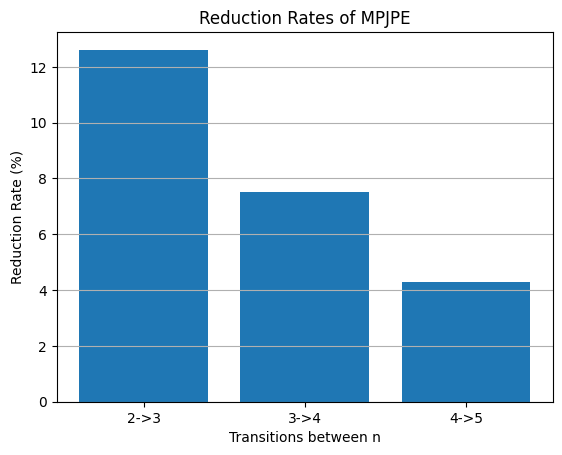

In [65]:
plt.figure()
plt.bar(range(2, 5), reduction_rates, tick_label=["2->3", "3->4", "4->5"])
plt.title("Reduction Rates of MPJPE")
plt.xlabel("Transitions between n")
plt.ylabel("Reduction Rate (%)")
plt.grid(axis='y')
plt.show()

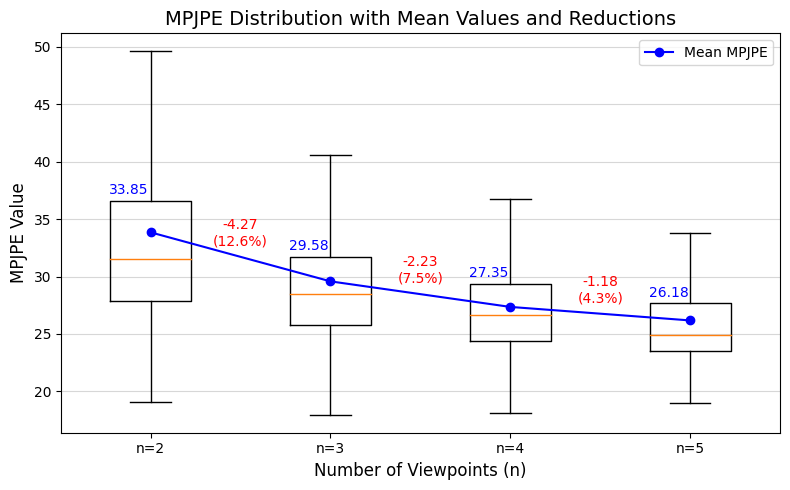

In [66]:
plt.figure(figsize=(8, 5))
boxplot_data = []
q3_values = []

for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    boxplot_data.append(values)
    q3_values.append(values.quantile(0.75))

plt.boxplot(boxplot_data, labels=[f"n={n}" for n in range(2, 6)], showfliers=False)

plt.plot(range(1, 5), mean_values, marker='o', linestyle='-', color='blue', label="Mean MPJPE")

for i, (start, end) in enumerate(zip(mean_values[:-1], mean_values[1:])):
    diff = start - end
    rate = diff / start * 100
    plt.text(i + 1.5, (start + end) / 2 + 1, f"-{diff:.2f}\n({rate:.1f}%)", ha='center', fontsize=10, color='red')

for i, (mean, q3) in enumerate(zip(mean_values, q3_values)):
    plt.text(i + 0.88, q3 + 0.6, f"{mean:.2f}", ha='center', fontsize=10, color='blue')

plt.title("MPJPE Distribution with Mean Values and Reductions", fontsize=14)
plt.xlabel("Number of Viewpoints (n)", fontsize=12)
plt.ylabel("MPJPE Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


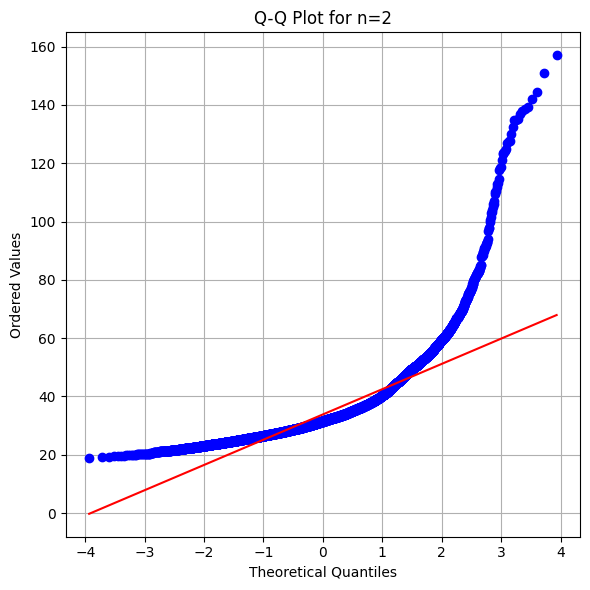

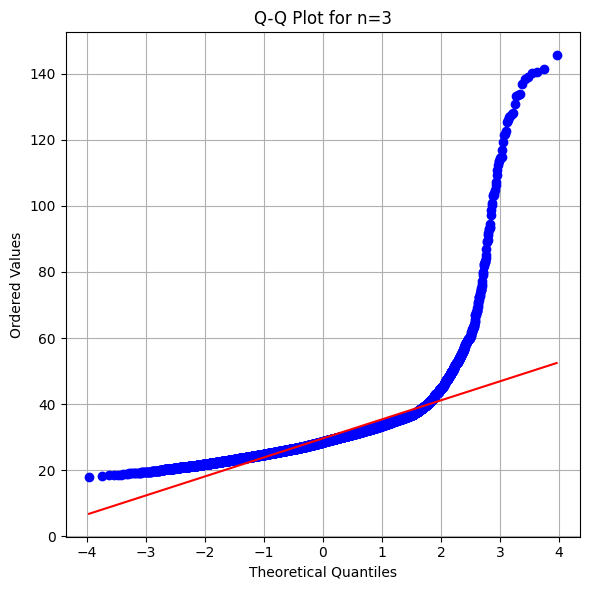

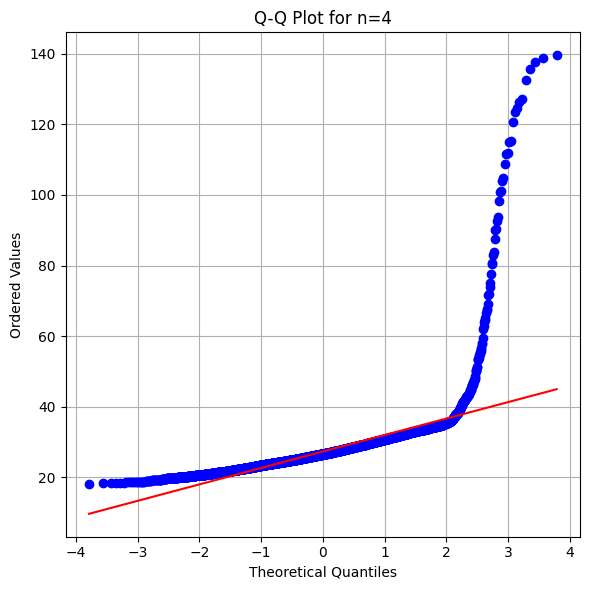

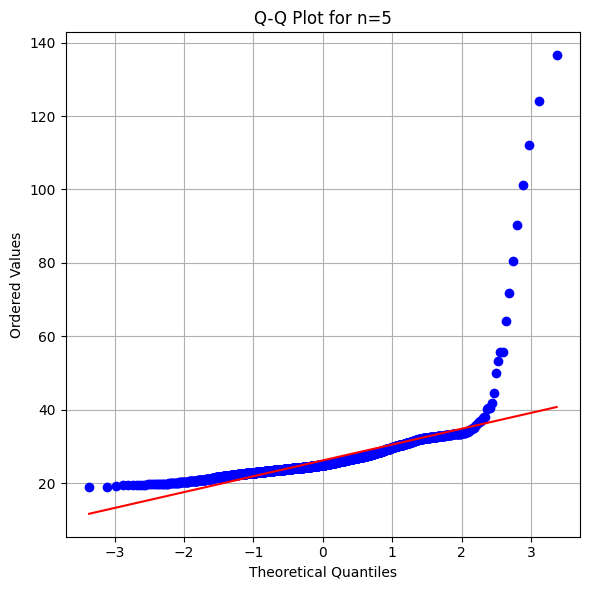

In [67]:
for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    plt.figure(figsize=(6, 6))
    probplot(values, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for n={n}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

n=2: stat=0.7581, p=0.0000
n=3: stat=0.6320, p=0.0000
n=4: stat=0.5394, p=0.0000
n=5: stat=0.4898, p=0.0000


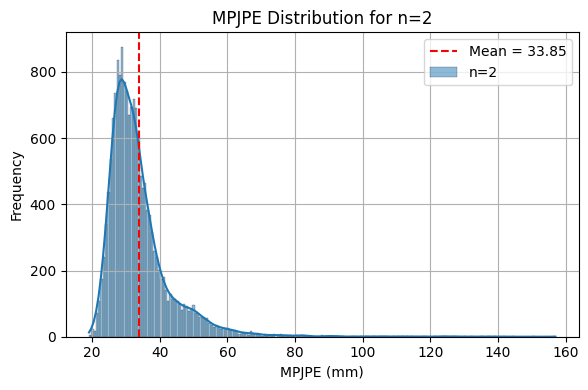

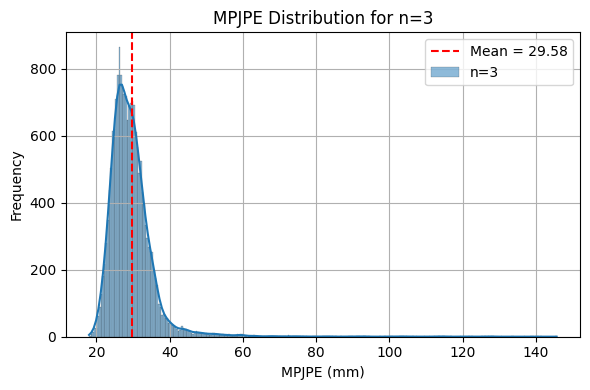

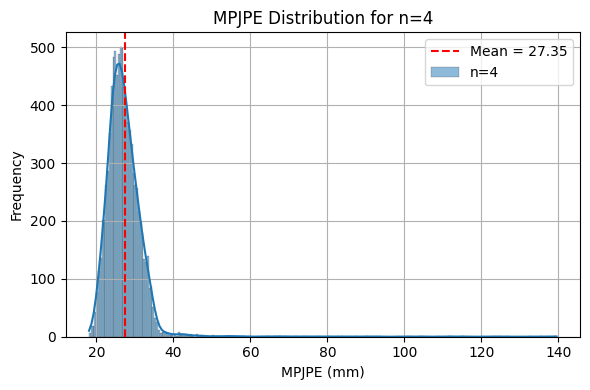

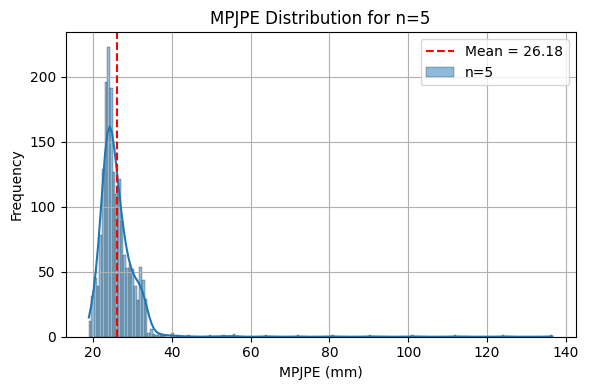

In [68]:
for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    stat, p = shapiro(values)
    print(f"n={n}: stat={stat:.4f}, p={p:.4f}")

for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    plt.figure(figsize=(6, 4))
    sns.histplot(values, kde=True, label=f"n={n}")
    mean_value = values.mean()
    plt.axvline(mean_value, color="red", linestyle="--", label=f"Mean = {mean_value:.2f}")
    plt.title(f"MPJPE Distribution for n={n}")
    plt.xlabel("MPJPE (mm)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

n=2 (trimmed): stat=0.8846, p=0.0000
n=3 (trimmed): stat=0.9337, p=0.0000
n=4 (trimmed): stat=0.9852, p=0.0000
n=5 (trimmed): stat=0.9537, p=0.0000


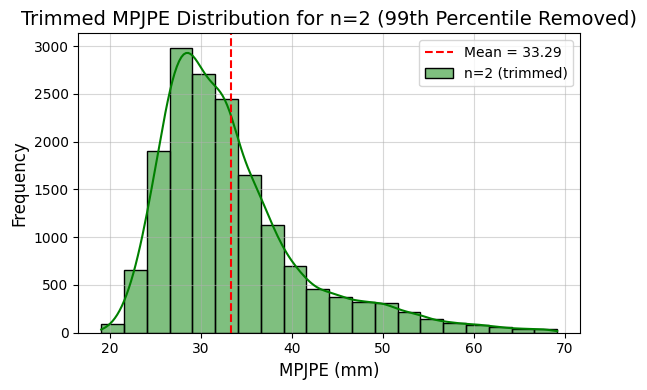

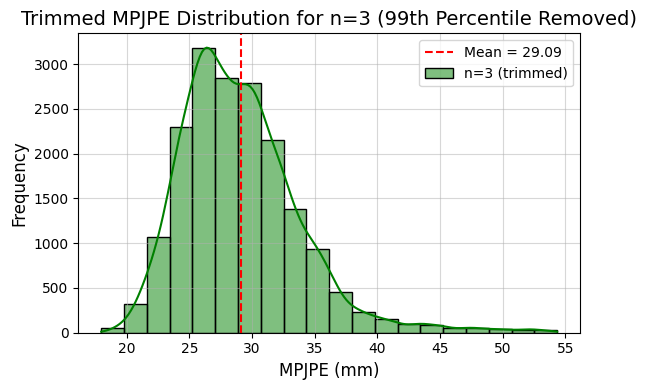

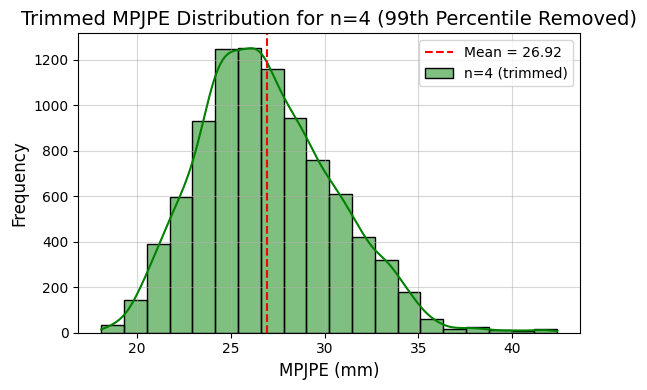

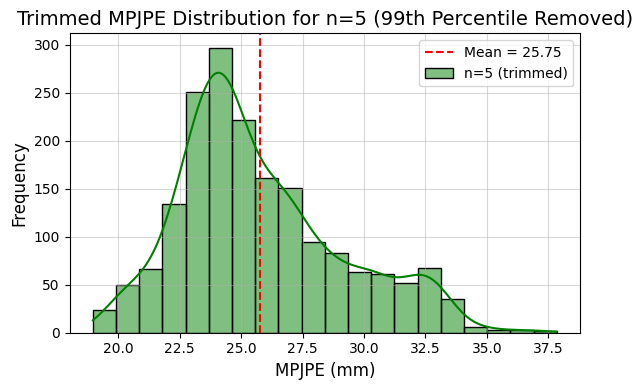

In [69]:
trimmed_results = []
for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    trimmed_values = values[values <= values.quantile(0.99)]
    stat, p = shapiro(trimmed_values)
    trimmed_results.append((n, stat, p))

for n, stat, p in trimmed_results:
    print(f"n={n} (trimmed): stat={stat:.4f}, p={p:.4f}")

for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    trimmed_values = values[values <= values.quantile(0.99)]
    plt.figure(figsize=(6, 4))
    sns.histplot(trimmed_values, kde=True, label=f"n={n} (trimmed)", color="green", bins=20)
    mean_value = trimmed_values.mean()
    plt.axvline(mean_value, color="red", linestyle="--", label=f"Mean = {mean_value:.2f}")
    plt.title(f"Trimmed MPJPE Distribution for n={n} (99th Percentile Removed)", fontsize=14)
    plt.xlabel("MPJPE (mm)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


Number of combinations for each n:
n=2: 18440
n=3: 18440
n=4: 9220
n=5: 1844
Two Camera Combination (04 vs Others):
KS Statistic: 0.5493, p-value: 0.0000


,Camera 04,Others
count,1844.00,16596.00
mean,65.91,33.85
std,51.71,9.95
min,26.66,19.04
25%,37.82,27.85
50%,46.76,31.52
75%,75.99,36.55
max,458.91,157.03


,Combination,Error Type,Error Value
0,01,MPJPE,31.56
1,01,MPJPE,32.11
2,01,MPJPE,35.39
3,01,MPJPE,33.97
4,01,MPJPE,30.75
...,...,...,...
334439,01234,MPJPE,34.52
334440,01234,MPJPE,36.56
334441,01234,MPJPE,40.43
334442,01234,MPJPE,41.69


Mean values for each n:
n=2: 33.85 ± 9.95
n=3: 29.58 ± 7.26
n=4: 27.35 ± 6.34
n=5: 26.18 ± 6.18
Decreasing rates for each n:
2 -> 3: 12.61
3 -> 4: 7.53
4 -> 5: 4.30
Diminishing rates for each n:
2 -> 3 -> 4: 5.09
3 -> 4 -> 5: 3.22
Levene's test: stat=513.0655, p=0.0000
Fligner-Killeen test: stat=2921.6424, p=0.0000
Kruskal-Wallis test: stat=7211.5310, p=0.0000

Cliff's Delta Effect Sizes (pairwise comparisons):
2 vs 3: 0.7236
3 vs 4: 0.6997
4 vs 5: 0.6161


,0,1,2,3,4
count,25816.00,27660.00,27660.00,27660.00,25816.00
mean,30.66,30.32,28.83,29.39,29.80
std,8.64,8.54,6.94,8.04,8.35
min,17.98,18.10,17.98,17.98,18.35
25%,25.90,25.60,25.12,25.18,25.39
50%,29.15,28.55,27.78,27.87,28.02
75%,32.81,32.48,31.16,31.19,31.98
max,157.03,150.89,141.94,157.03,145.66


Minimum combinations for each n:
n=2: 23
n=3: 123
n=4: 1234
n=5: 01234

Mean values for minimum combinations:
n=2: 27.92
n=3: 27.05
n=4: 25.86
n=5: 26.18
Kruskal-Wallis test (minimum combinations): stat=506.6030, p=0.0000

Cliff's Delta Effect Sizes (minimum combinations):
2 vs 3: 0.6746
3 vs 4: 0.7644
4 vs 5: 0.5827
--- Right Elbow Error Analysis: ---
Mean values for each n:
  n=2: 6.00 ± 7.11
  n=3: 4.37 ± 4.22
  n=4: 3.59 ± 2.96
  n=5: 3.11 ± 2.14
Decreasing rates for each n:
  2 -> 3: 27.17
  3 -> 4: 17.82
  4 -> 5: 13.28
Diminishing rates for each n:
  2 -> 3 -> 4: 9.36
  3 -> 4 -> 5: 4.54

--- Left Elbow Error Analysis: ---
Mean values for each n:
  n=2: 5.50 ± 9.74
  n=3: 4.04 ± 7.55
  n=4: 3.27 ± 6.75
  n=5: 2.78 ± 6.52
Decreasing rates for each n:
  2 -> 3: 26.43
  3 -> 4: 19.03
  4 -> 5: 15.24
Diminishing rates for each n:
  2 -> 3 -> 4: 7.40
  3 -> 4 -> 5: 3.79

--- Right Knee Error Analysis: ---
Mean values for each n:
  n=2: 3.57 ± 2.72
  n=3: 3.18 ± 2.15
  n=4: 2.99 ± 1.9

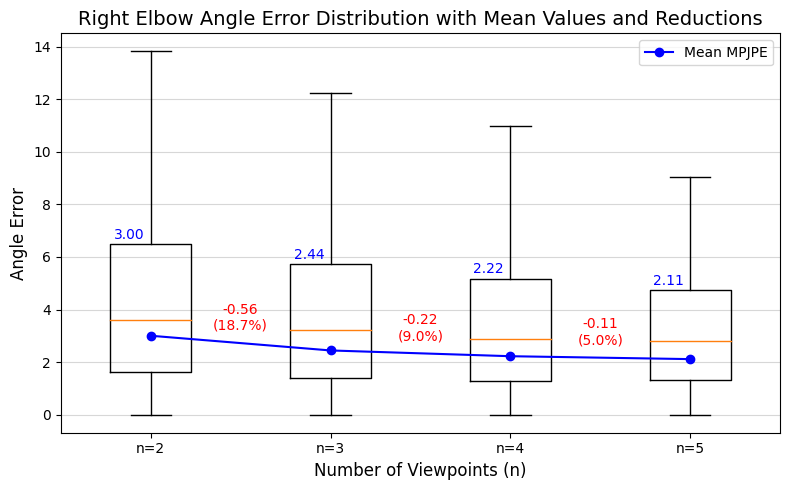

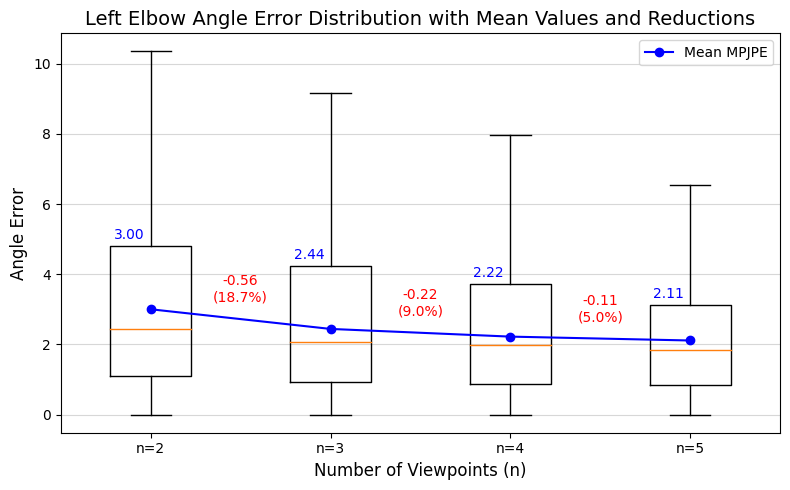

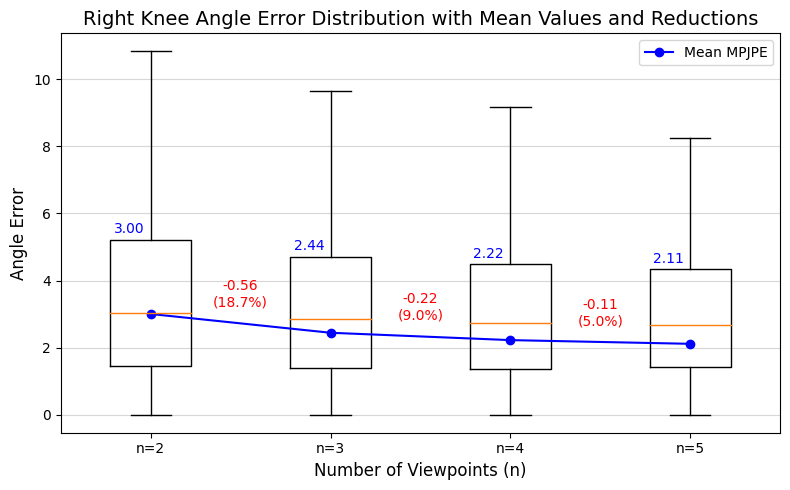

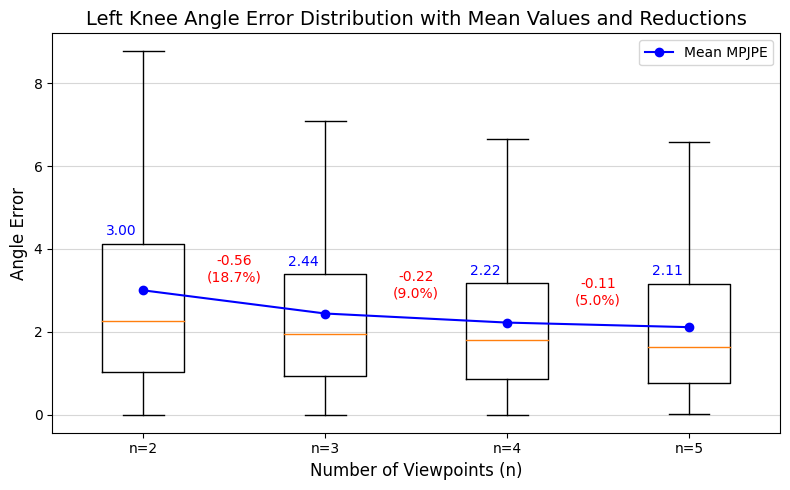

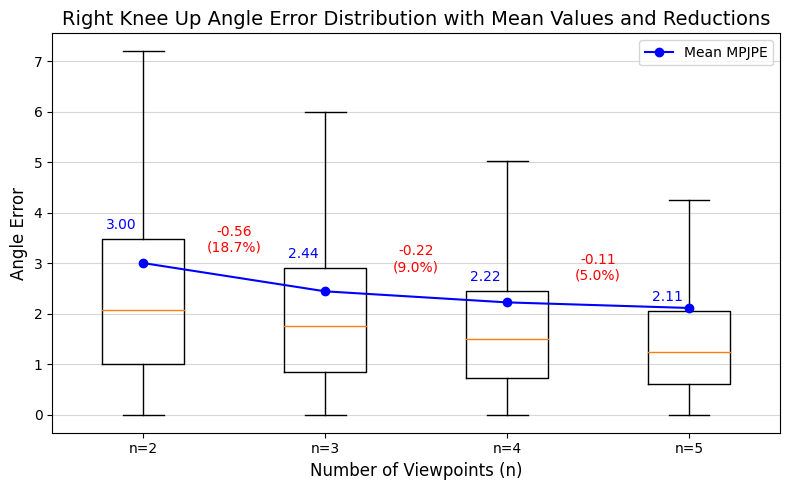

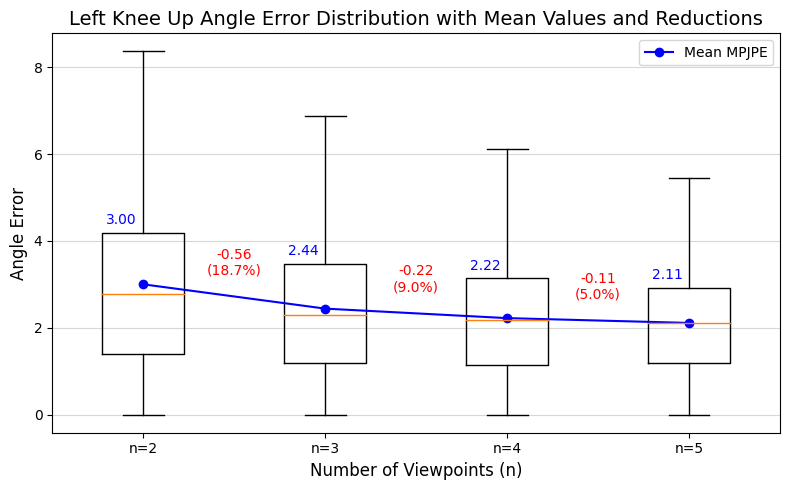

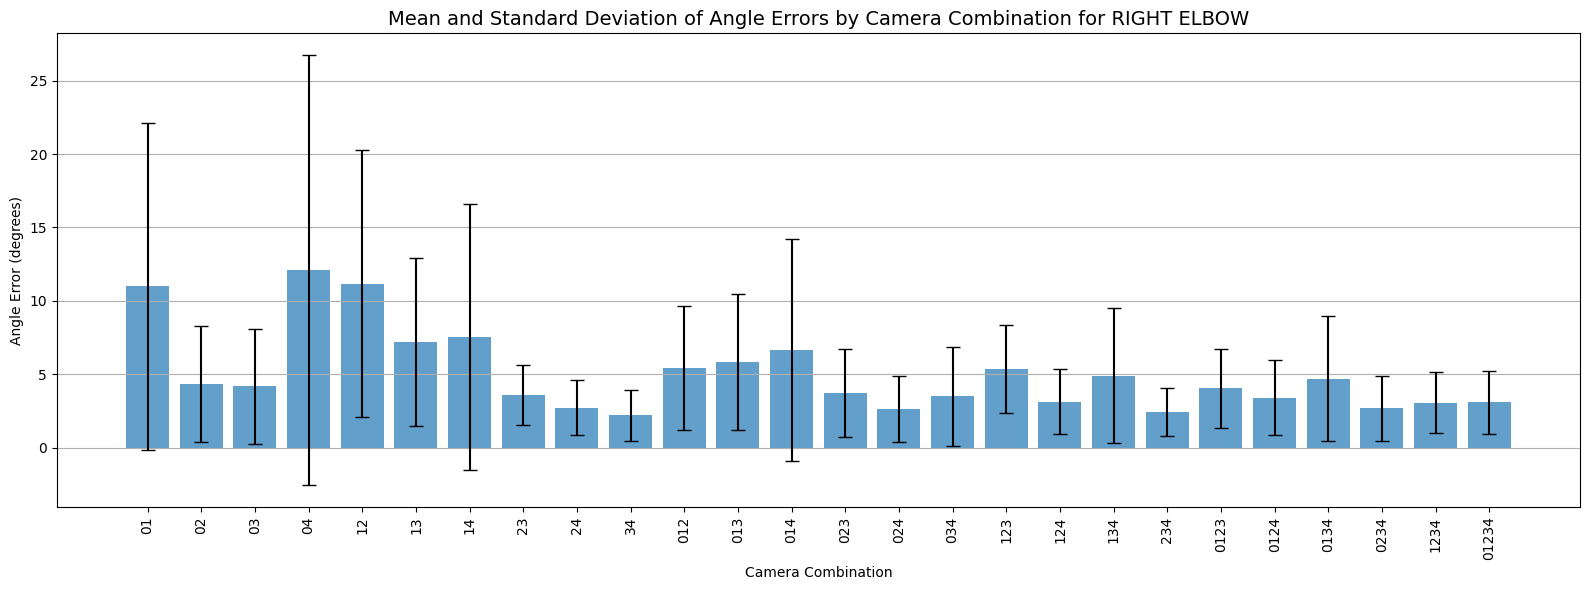

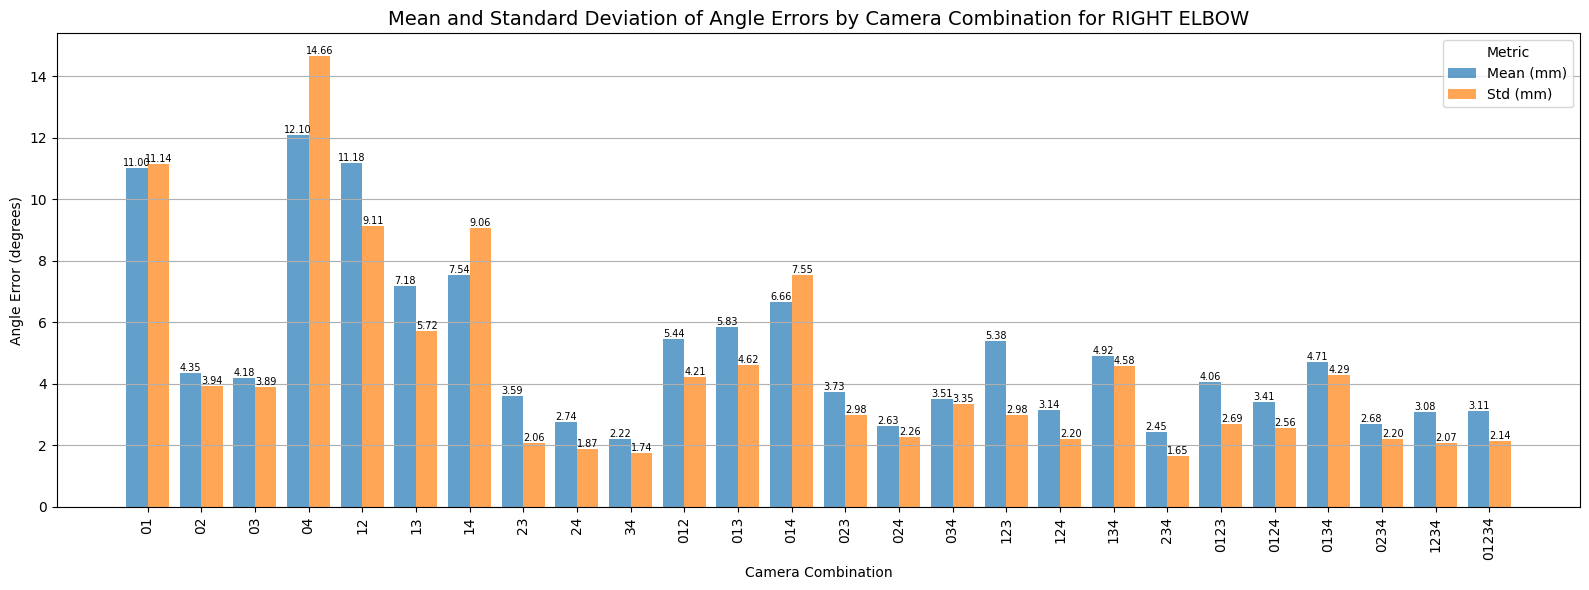

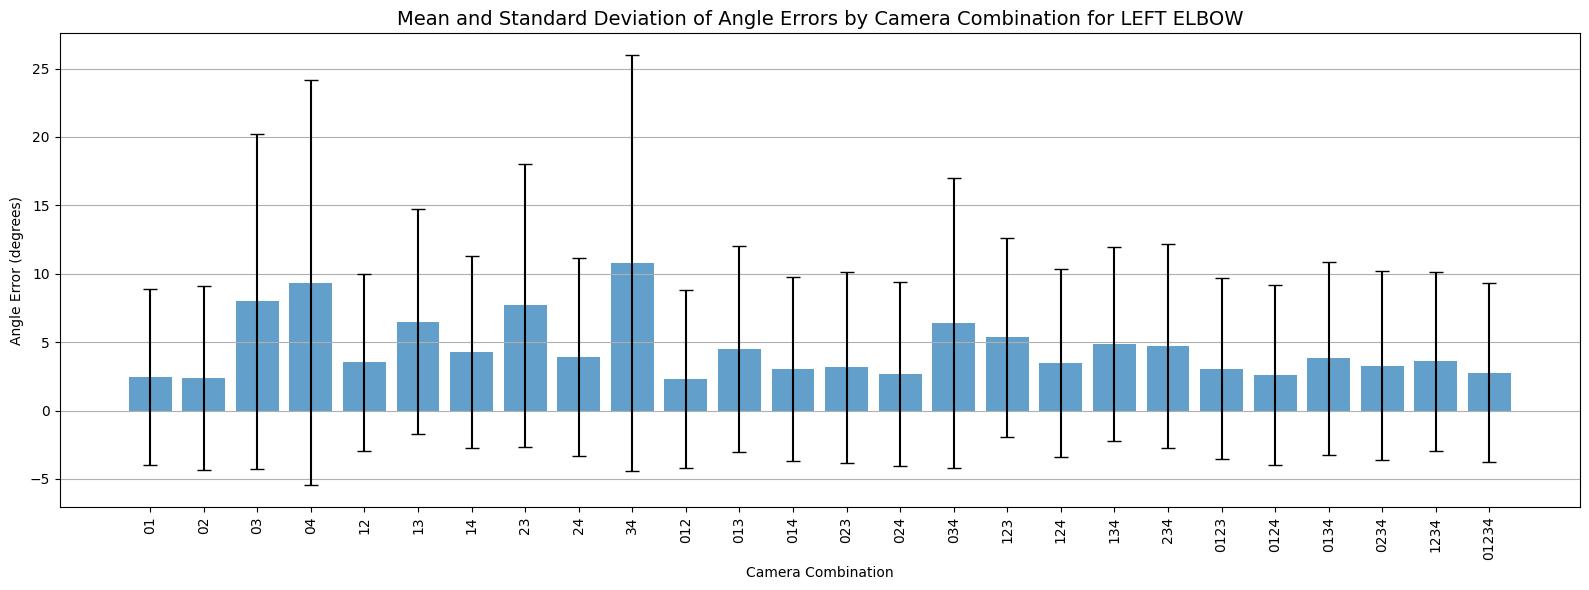

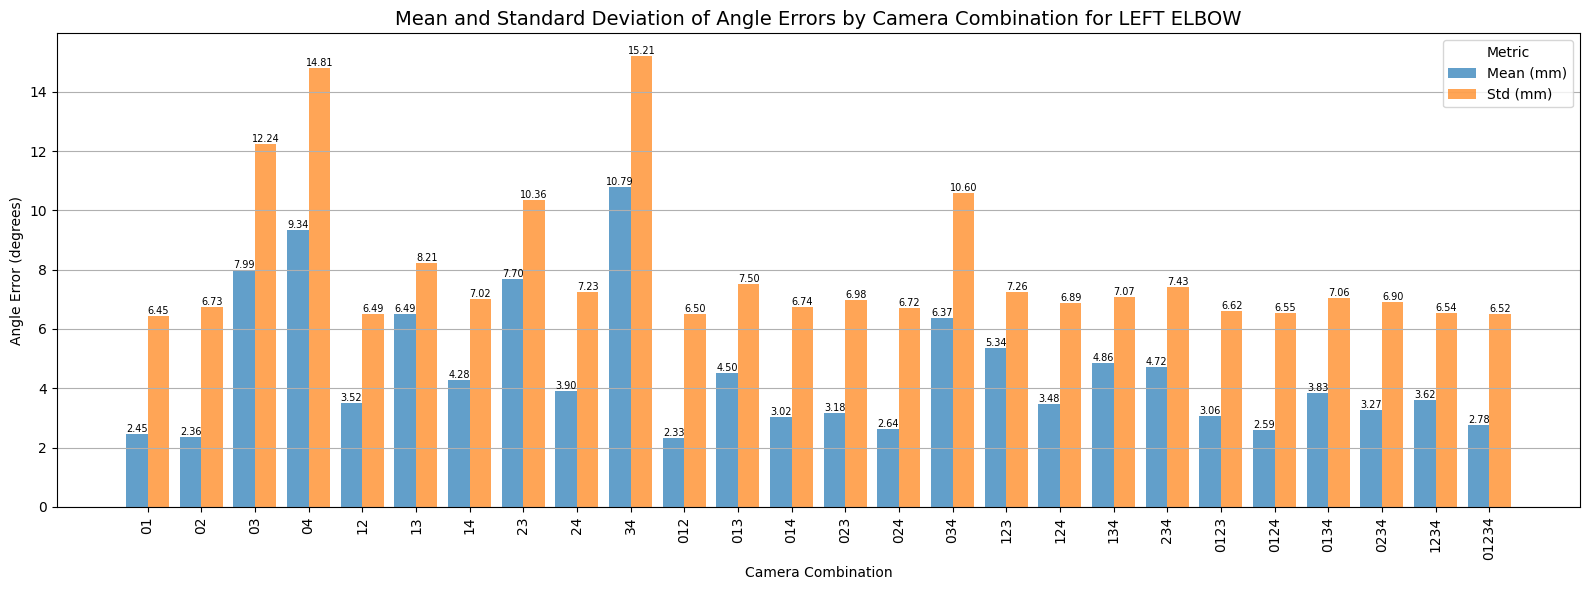

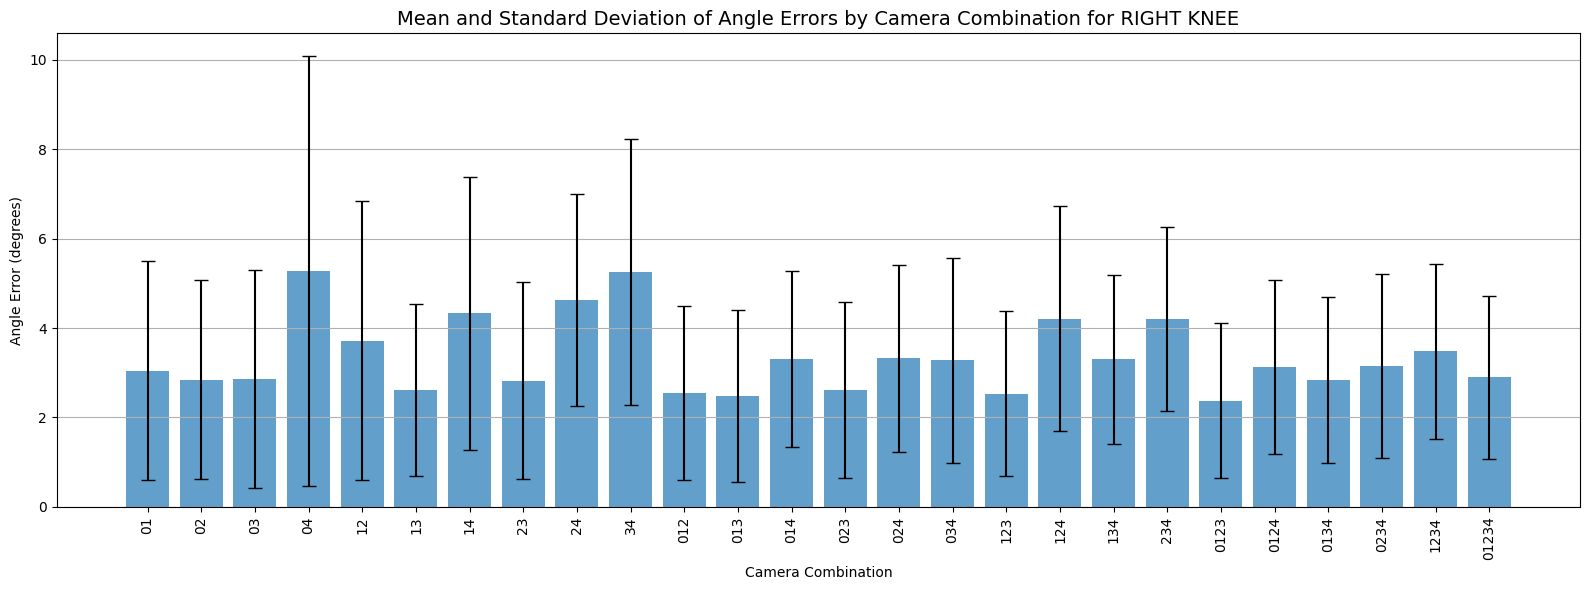

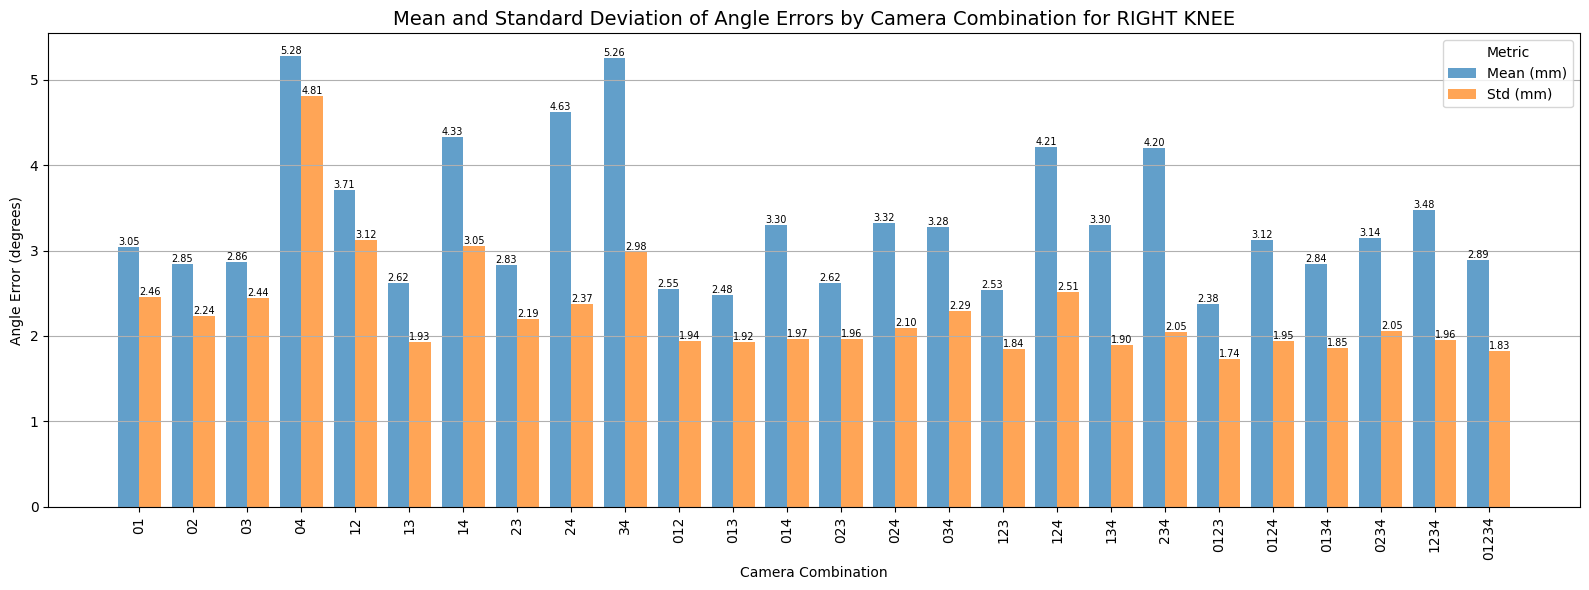

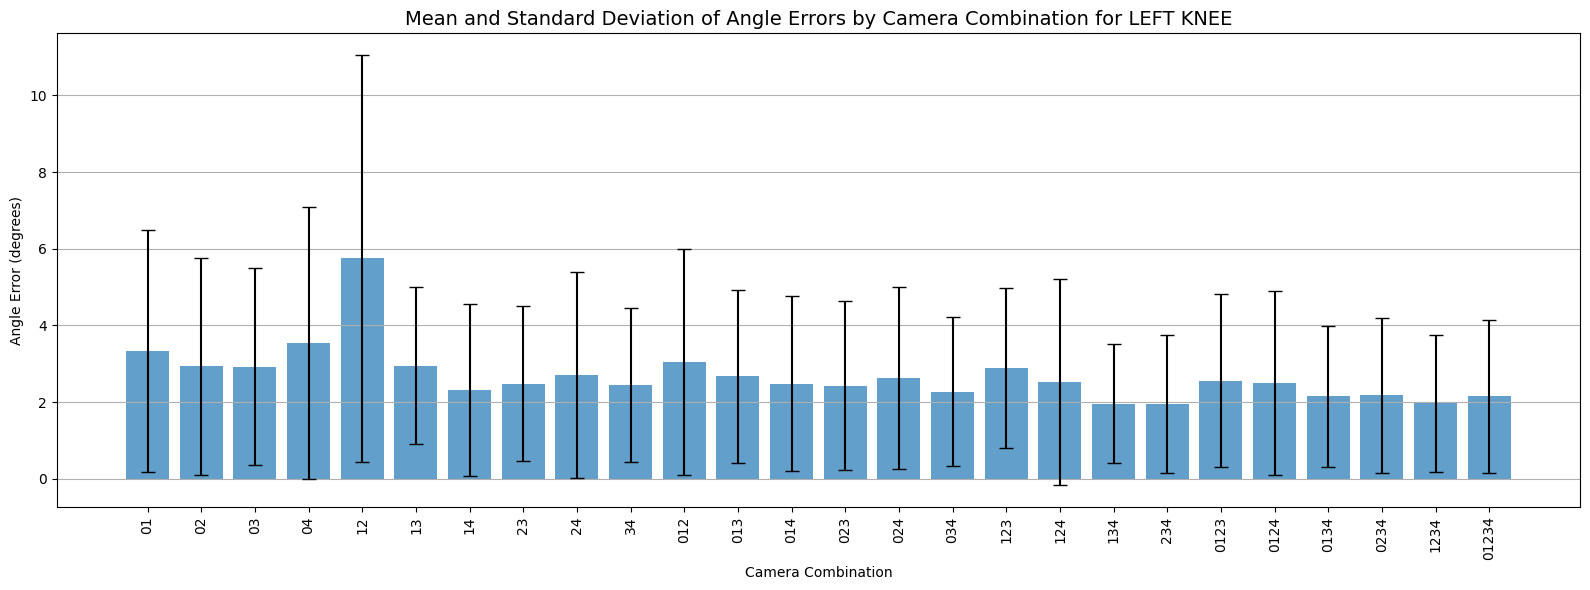

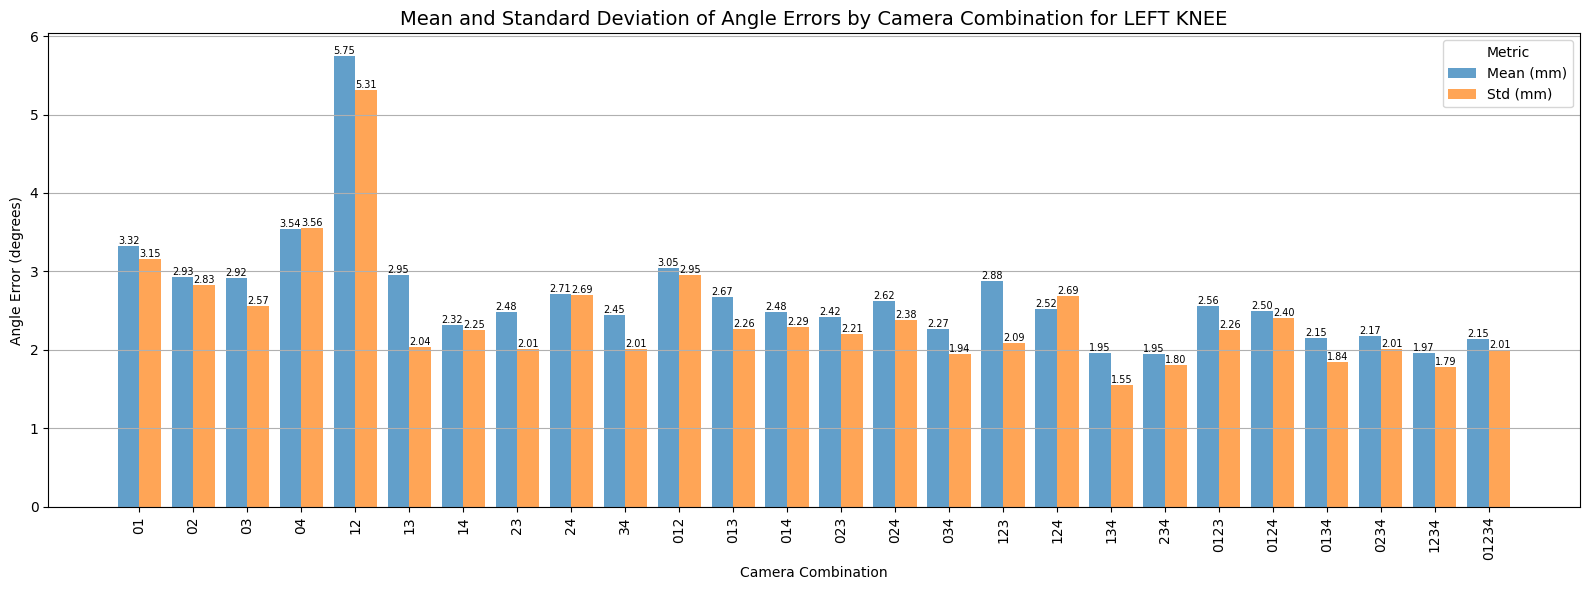

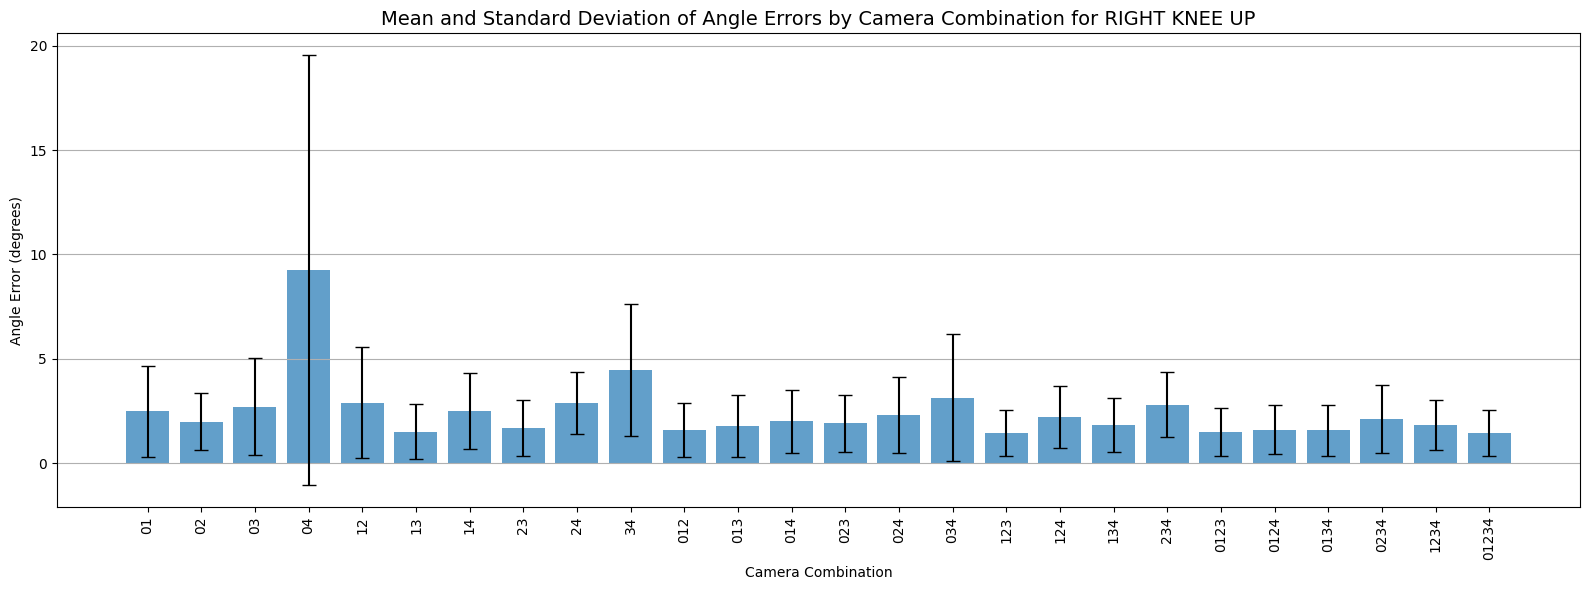

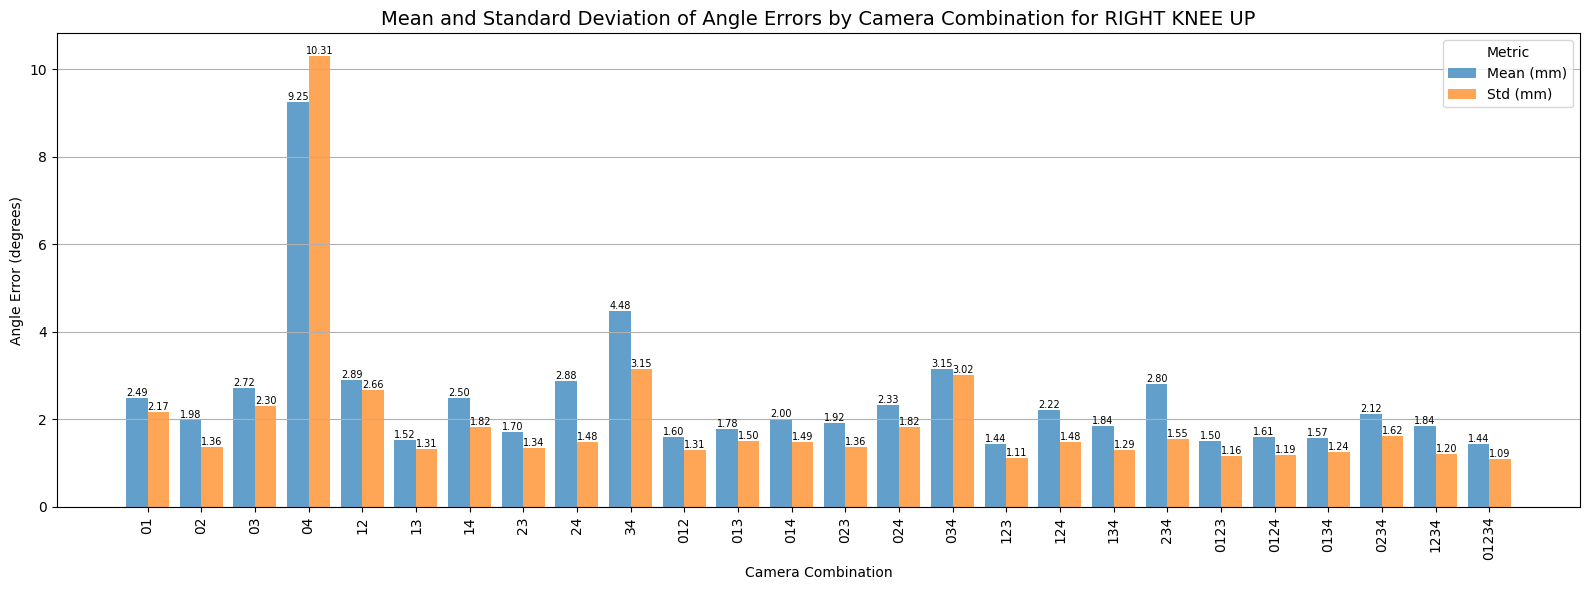

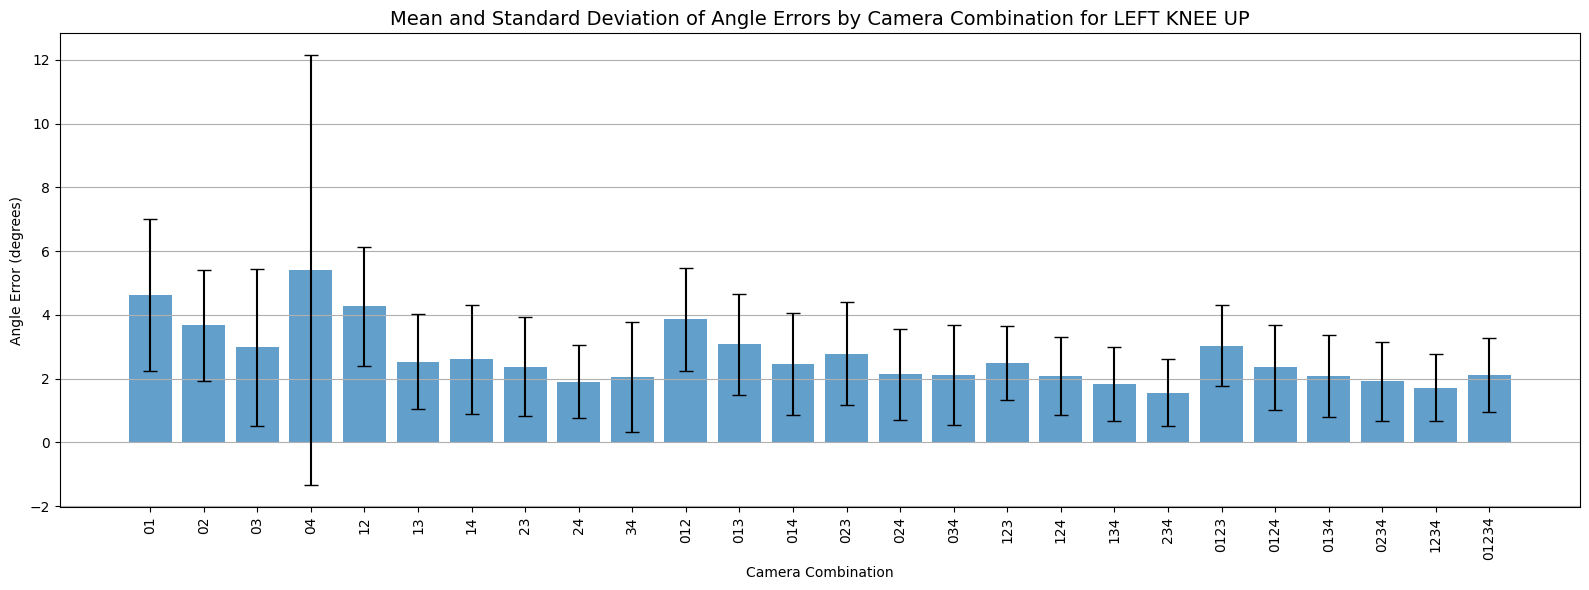

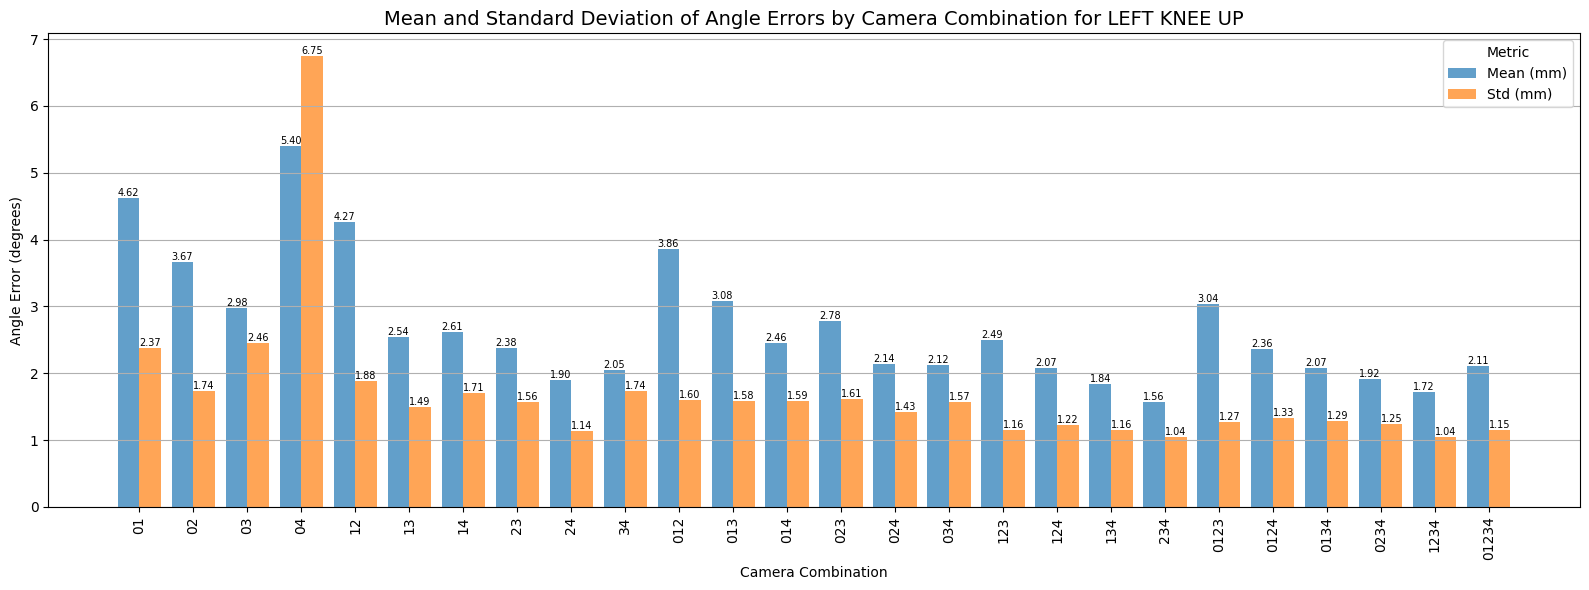

In [70]:
import os

import pandas as pd
from IPython.display import display

pd.options.display.float_format = '{:.2f}'.format
import warnings
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import *
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings("ignore")
file_paths = [f"error/hirasaki_{i}_errors.csv" for i in range(10)]
dataframes = [pd.read_csv(file_path) for file_path in file_paths]
frame_wise_avg_mpjpe_combinations_revised = {n: [] for n in range(2, 6)}

for n in range(5):
    for combo_indices in combinations(range(5), n + 2):
        for df in dataframes:
            combo_col_name = f"{''.join(map(str, combo_indices))}_mpjpe"
            if combo_col_name in df.columns:
                frame_wise_avg_mpjpe_combinations_revised[n + 2].extend(df[combo_col_name].values)

print("Number of combinations for each n:")
for n, values in frame_wise_avg_mpjpe_combinations_revised.items():
    print(f"n={n}: {len(values)}")
raw_combination_data = []
for df in dataframes:
    for col in df.columns:
        if "_mpjpe" in col or "_angle" in col:
            error_type = "MPJPE" if "_mpjpe" in col else col.split('_')[1] + " " + col.split('_')[2]
            if len(col.split('_')) == 6:
                error_type += " " + col.split('_')[3]
            error_type = error_type.replace("NKEE", "KNEE")
            for value in df[col].values:
                raw_combination_data.append({"Combination": col.split('_')[0], "Error Type": error_type, "Error Value": value})

raw_combination_df = pd.DataFrame(raw_combination_data)
raw_combination_df.head()
camera04_two_camera_data = raw_combination_df[
    (raw_combination_df["Error Type"] == "MPJPE") &
    (raw_combination_df["Combination"].str.len() == 2) &
    (raw_combination_df["Combination"].str.contains("04"))
]["Error Value"]

other_two_camera_data = raw_combination_df[
    (raw_combination_df["Error Type"] == "MPJPE") &
    (raw_combination_df["Combination"].str.len() == 2) &
    (~raw_combination_df["Combination"].str.contains("04"))
]["Error Value"]

ks_stat_two_camera, ks_pvalue_two_camera = ks_2samp(camera04_two_camera_data, other_two_camera_data)
print(f"Two Camera Combination (04 vs Others):")
print(f"KS Statistic: {ks_stat_two_camera:.4f}, p-value: {ks_pvalue_two_camera:.4f}")
stat_df = pd.DataFrame()
stat_df['Camera 04'] = camera04_two_camera_data.describe()
stat_df['Others'] = other_two_camera_data.describe()
display(stat_df)
mpjpe_df = raw_combination_df[(raw_combination_df["Error Type"] == "MPJPE") & (raw_combination_df["Combination"] != "04")]
display(mpjpe_df)
mean_values = [mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"].mean() for n in range(2, 6)]
std_values = [mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"].std() for n in range(2, 6)]

print("Mean values for each n:")
for n, mean, std in zip(range(2, 6), mean_values, std_values):
    print(f"n={n}: {mean:.2f} ± {std:.2f}")

reduction_rates = [(mean_values[n] - mean_values[n + 1]) / mean_values[n] * 100 for n in range(3)]
print(f"Decreasing rates for each n:")
for n, rate in enumerate(reduction_rates):
    print(f"{n + 2} -> {n + 3}: {rate:.2f}")

diminishing_rates = [reduction_rates[n] - reduction_rates[n + 1] for n in range(2)]
print(f"Diminishing rates for each n:")
for n, rate in enumerate(diminishing_rates):
    print(f"{n + 2} -> {n + 3} -> {n + 4}: {rate:.2f}")
values_2 = mpjpe_df[mpjpe_df["Combination"].str.len() == 2]["Error Value"]
values_3 = mpjpe_df[mpjpe_df["Combination"].str.len() == 3]["Error Value"]
values_4 = mpjpe_df[mpjpe_df["Combination"].str.len() == 4]["Error Value"]
values_5 = mpjpe_df[mpjpe_df["Combination"].str.len() == 5]["Error Value"]

stat_levene, p_levene = levene(values_2, values_3, values_4, values_5)
print(f"Levene's test: stat={stat_levene:.4f}, p={p_levene:.4f}")

stat_fligner, p_fligner = fligner(values_2, values_3, values_4, values_5)
print(f"Fligner-Killeen test: stat={stat_fligner:.4f}, p={p_fligner:.4f}")

stat_kruskal, p_kruskal = kruskal(values_2, values_3, values_4, values_5)

def cliffs_delta(a, b):
    m, n = len(a), len(b)
    rank = np.argsort(np.concatenate([a, b]))
    a_ranks = np.sum(rank[:m])
    b_ranks = np.sum(rank[m:])
    return (2 * a_ranks / m - (m + 1)) / n - 0.5

cliffs_effects = {
    f"{n1} vs {n2}": cliffs_delta(
        mpjpe_df[mpjpe_df["Combination"].str.len() == n1]["Error Value"],
        mpjpe_df[mpjpe_df["Combination"].str.len() == n2]["Error Value"],
    )
    for n1, n2 in [(2, 3), (3, 4), (4, 5)]
}

print(f"Kruskal-Wallis test: stat={stat_kruskal:.4f}, p={p_kruskal:.4f}")
print("\nCliff's Delta Effect Sizes (pairwise comparisons):")
for pair, delta in cliffs_effects.items():
    print(f"{pair}: {delta:.4f}")
stat_df = pd.DataFrame()
stat_df["0"] = mpjpe_df[mpjpe_df.Combination.str.contains("0")]["Error Value"].describe()
stat_df["1"] = mpjpe_df[mpjpe_df.Combination.str.contains("1")]["Error Value"].describe()
stat_df["2"] = mpjpe_df[mpjpe_df.Combination.str.contains("2")]["Error Value"].describe()
stat_df["3"] = mpjpe_df[mpjpe_df.Combination.str.contains("3")]["Error Value"].describe()
stat_df["4"] = mpjpe_df[mpjpe_df.Combination.str.contains("4")]["Error Value"].describe()
display(stat_df)
min_comb_2 = pd.DataFrame(mpjpe_df[mpjpe_df["Combination"].str.len() == 2].groupby("Combination")["Error Value"].mean()).sort_values("Error Value").index[0]
min_comb_3 = pd.DataFrame(mpjpe_df[mpjpe_df["Combination"].str.len() == 3].groupby("Combination")["Error Value"].mean()).sort_values("Error Value").index[0]
min_comb_4 = pd.DataFrame(mpjpe_df[mpjpe_df["Combination"].str.len() == 4].groupby("Combination")["Error Value"].mean()).sort_values("Error Value").index[0]
min_comb_5 = pd.DataFrame(mpjpe_df[mpjpe_df["Combination"].str.len() == 5].groupby("Combination")["Error Value"].mean()).sort_values("Error Value").index[0]

print(f"Minimum combinations for each n:")
print(f"n=2: {min_comb_2}")
print(f"n=3: {min_comb_3}")
print(f"n=4: {min_comb_4}")
print(f"n=5: {min_comb_5}")

values_2_min = mpjpe_df[mpjpe_df["Combination"] == min_comb_2]["Error Value"]
values_3_min = mpjpe_df[mpjpe_df["Combination"] == min_comb_3]["Error Value"]
values_4_min = mpjpe_df[mpjpe_df["Combination"] == min_comb_4]["Error Value"]
values_5_min = mpjpe_df[mpjpe_df["Combination"] == min_comb_5]["Error Value"]

print("\nMean values for minimum combinations:")
print(f"n=2: {values_2_min.mean():.2f}")
print(f"n=3: {values_3_min.mean():.2f}")
print(f"n=4: {values_4_min.mean():.2f}")
print(f"n=5: {values_5_min.mean():.2f}")

stat_kruskal_min, p_kruskal_min = kruskal(values_2_min, values_3_min, values_4_min, values_5_min)
print(f"Kruskal-Wallis test (minimum combinations): stat={stat_kruskal_min:.4f}, p={p_kruskal_min:.4f}")

cliffs_effects_min = {
    f"{n1} vs {n2}": cliffs_delta(
        mpjpe_df[mpjpe_df["Combination"] == globals()[f"min_comb_{n1}"]]["Error Value"],
        mpjpe_df[mpjpe_df["Combination"] == globals()[f"min_comb_{n2}"]]["Error Value"],
    )
    for n1, n2 in [(2, 3), (3, 4), (4, 5)]
}

print("\nCliff's Delta Effect Sizes (minimum combinations):")
for pair, delta in cliffs_effects_min.items():
    print(f"{pair}: {delta:.4f}")
right_elbow_df = raw_combination_df[(raw_combination_df["Error Type"] == "RIGHT ELBOW") & (raw_combination_df["Combination"] != "04")]
left_elbow_df = raw_combination_df[(raw_combination_df["Error Type"] == "LEFT ELBOW") & (raw_combination_df["Combination"] != "04")]
right_knee_df = raw_combination_df[(raw_combination_df["Error Type"] == "RIGHT KNEE") & (raw_combination_df["Combination"] != "04")]
left_knee_df = raw_combination_df[(raw_combination_df["Error Type"] == "LEFT KNEE") & (raw_combination_df["Combination"] != "04")]
right_knee_up_df = raw_combination_df[(raw_combination_df["Error Type"] == "RIGHT KNEE UP") & (raw_combination_df["Combination"] != "04")]
left_knee_up_df = raw_combination_df[(raw_combination_df["Error Type"] == "LEFT KNEE UP") & (raw_combination_df["Combination"] != "04")]
angle_dict = {
    "Right Elbow": right_elbow_df,
    "Left Elbow": left_elbow_df,
    "Right Knee": right_knee_df,
    "Left Knee": left_knee_df,
    "Right Knee Up": right_knee_up_df,
    "Left Knee Up": left_knee_up_df,
}
for angle, df in angle_dict.items():
    print(f"--- {angle} Error Analysis: ---")
    mean_values = [df[df["Combination"].str.len() == n]["Error Value"].mean() for n in range(2, 6)]
    std_values = [df[df["Combination"].str.len() == n]["Error Value"].std() for n in range(2, 6)]

    print("Mean values for each n:")
    for n, mean, std in zip(range(2, 6), mean_values, std_values):
        print(f"  n={n}: {mean:.2f} ± {std:.2f}")

    reduction_rates = [(mean_values[n] - mean_values[n + 1]) / mean_values[n] * 100 for n in range(3)]
    print(f"Decreasing rates for each n:")
    for n, rate in enumerate(reduction_rates):
        print(f"  {n + 2} -> {n + 3}: {rate:.2f}")

    diminishing_rates = [reduction_rates[n] - reduction_rates[n + 1] for n in range(2)]
    print(f"Diminishing rates for each n:")
    for n, rate in enumerate(diminishing_rates):
        print(f"  {n + 2} -> {n + 3} -> {n + 4}: {rate:.2f}")
    
    print()
for angle, df in angle_dict.items():
    plt.figure(figsize=(8, 5))
    boxplot_data = []
    q3_values = []

    for n in range(2, 6):
        values = df[df["Combination"].str.len() == n]["Error Value"]
        boxplot_data.append(values)
        q3_values.append(values.quantile(0.75))

    plt.boxplot(boxplot_data, labels=[f"n={n}" for n in range(2, 6)], showfliers=False)

    plt.plot(range(1, 5), mean_values, marker='o', linestyle='-', color='blue', label="Mean MPJPE")

    for i, (start, end) in enumerate(zip(mean_values[:-1], mean_values[1:])):
        diff = start - end
        rate = diff / start * 100
        plt.text(i + 1.5, (start + end) / 2 + 0.5, f"-{diff:.2f}\n({rate:.1f}%)", ha='center', fontsize=10, color='red')

    for i, (mean, q3) in enumerate(zip(mean_values, q3_values)):
        plt.text(i + 0.88, q3 + 0.2, f"{mean:.2f}", ha='center', fontsize=10, color='blue')

    plt.title(f"{angle} Angle Error Distribution with Mean Values and Reductions", fontsize=14)
    plt.xlabel("Number of Viewpoints (n)", fontsize=12)
    plt.ylabel("Angle Error", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()
combination_order = raw_combination_df["Combination"].unique()

for angle in ["RIGHT ELBOW", "LEFT ELBOW", "RIGHT KNEE", "LEFT KNEE", "RIGHT KNEE UP", "LEFT KNEE UP"]:
    mean_values = raw_combination_df[raw_combination_df["Error Type"] == angle].groupby("Combination")["Error Value"].mean().reindex(combination_order)
    std_values = raw_combination_df[raw_combination_df["Error Type"] == angle].groupby("Combination")["Error Value"].std().reindex(combination_order)

    plt.figure(figsize=(16, 6))
    plt.bar(mean_values.index, mean_values, yerr=std_values, capsize=5, alpha=0.7)
    plt.xticks(rotation=90)
    plt.title("Mean and Standard Deviation of Angle Errors by Camera Combination for " + angle, fontsize=14)
    plt.xlabel("Camera Combination")
    plt.ylabel("Angle Error (degrees)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    x = range(len(mean_values))
    bar_width = 0.4

    plt.figure(figsize=(16, 6))
    mean_bars = plt.bar(x, mean_values, width=bar_width, label='Mean (mm)', alpha=0.7)
    std_bars = plt.bar([p + bar_width for p in x], std_values, width=bar_width, label='Std (mm)', alpha=0.7)

    for bar, mean in zip(mean_bars, mean_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mean:.2f}', ha='center', va='bottom', fontsize=7, color='black')
    for bar, std in zip(std_bars, std_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{std:.2f}', ha='center', va='bottom', fontsize=7, color='black')

    plt.xticks([p + bar_width / 2 for p in x], mean_values.index, rotation=90)
    plt.title("Mean and Standard Deviation of Angle Errors by Camera Combination for " + angle, fontsize=14)
    plt.xlabel("Camera Combination")
    plt.ylabel("Angle Error (degrees)")
    plt.legend(title="Metric")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [71]:
angle_dict = {
    "Right Elbow": right_elbow_df,
    "Left Elbow": left_elbow_df,
    "Right Knee": right_knee_df,
    "Left Knee": left_knee_df,
    "Right Knee Up": right_knee_up_df,
    "Left Knee Up": left_knee_up_df,
}

In [72]:
for angle, df in angle_dict.items():
    print(f"--- {angle} Error Analysis: ---")
    mean_values = [df[df["Combination"].str.len() == n]["Error Value"].mean() for n in range(2, 6)]
    std_values = [df[df["Combination"].str.len() == n]["Error Value"].std() for n in range(2, 6)]

    print("Mean values for each n:")
    for n, mean, std in zip(range(2, 6), mean_values, std_values):
        print(f"  n={n}: {mean:.2f} ± {std:.2f}")

    reduction_rates = [(mean_values[n] - mean_values[n + 1]) / mean_values[n] * 100 for n in range(3)]
    print(f"Decreasing rates for each n:")
    for n, rate in enumerate(reduction_rates):
        print(f"  {n + 2} -> {n + 3}: {rate:.2f}")

    diminishing_rates = [reduction_rates[n] - reduction_rates[n + 1] for n in range(2)]
    print(f"Diminishing rates for each n:")
    for n, rate in enumerate(diminishing_rates):
        print(f"  {n + 2} -> {n + 3} -> {n + 4}: {rate:.2f}")
    
    print()

--- Right Elbow Error Analysis: ---
Mean values for each n:
  n=2: 6.00 ± 7.11
  n=3: 4.37 ± 4.22
  n=4: 3.59 ± 2.96
  n=5: 3.11 ± 2.14
Decreasing rates for each n:
  2 -> 3: 27.17
  3 -> 4: 17.82
  4 -> 5: 13.28
Diminishing rates for each n:
  2 -> 3 -> 4: 9.36
  3 -> 4 -> 5: 4.54

--- Left Elbow Error Analysis: ---
Mean values for each n:
  n=2: 5.50 ± 9.74
  n=3: 4.04 ± 7.55
  n=4: 3.27 ± 6.75
  n=5: 2.78 ± 6.52
Decreasing rates for each n:
  2 -> 3: 26.43
  3 -> 4: 19.03
  4 -> 5: 15.24
Diminishing rates for each n:
  2 -> 3 -> 4: 7.40
  3 -> 4 -> 5: 3.79

--- Right Knee Error Analysis: ---
Mean values for each n:
  n=2: 3.57 ± 2.72
  n=3: 3.18 ± 2.15
  n=4: 2.99 ± 1.95
  n=5: 2.89 ± 1.83
Decreasing rates for each n:
  2 -> 3: 10.93
  3 -> 4: 5.87
  4 -> 5: 3.28
Diminishing rates for each n:
  2 -> 3 -> 4: 5.06
  3 -> 4 -> 5: 2.59

--- Left Knee Error Analysis: ---
Mean values for each n:
  n=2: 3.09 ± 3.09
  n=3: 2.48 ± 2.28
  n=4: 2.27 ± 2.08
  n=5: 2.15 ± 2.01
Decreasing rates f

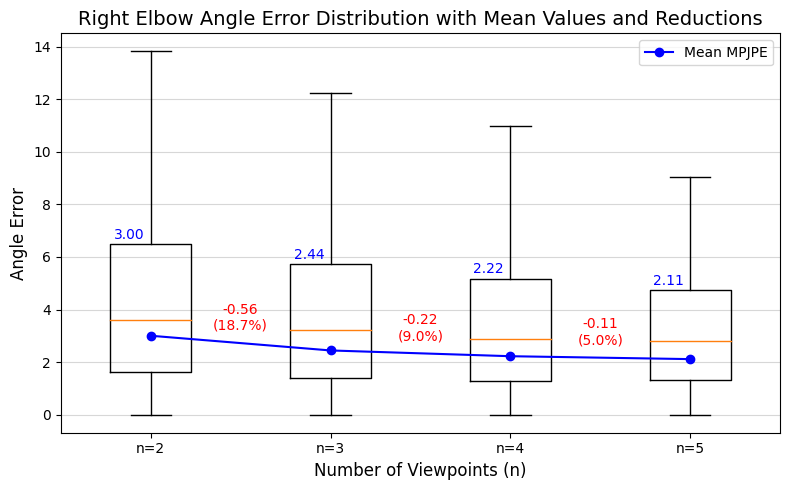

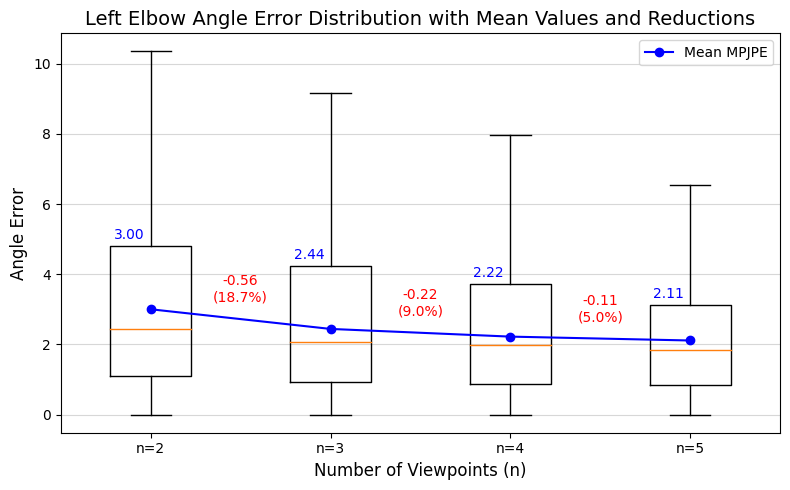

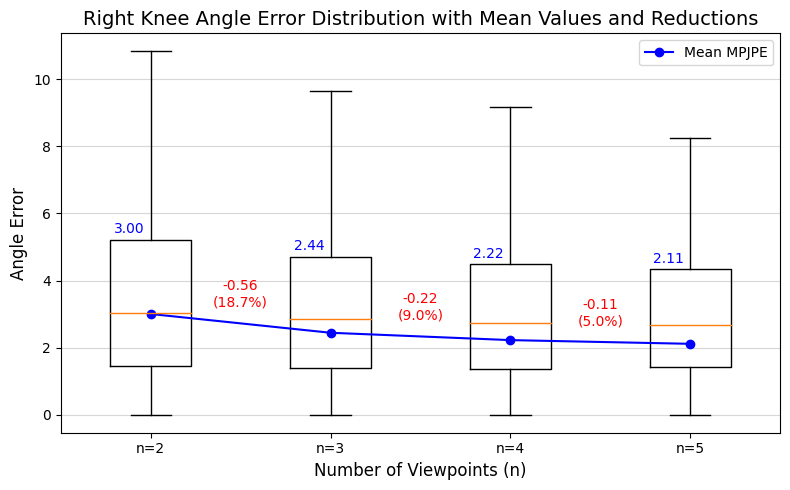

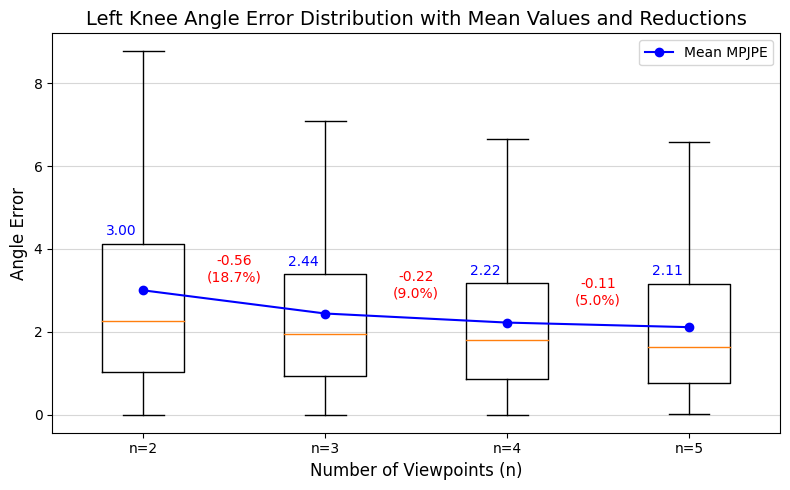

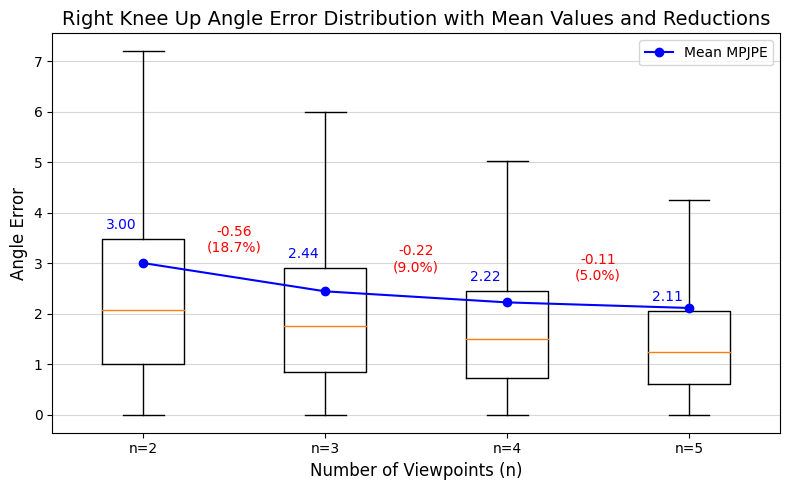

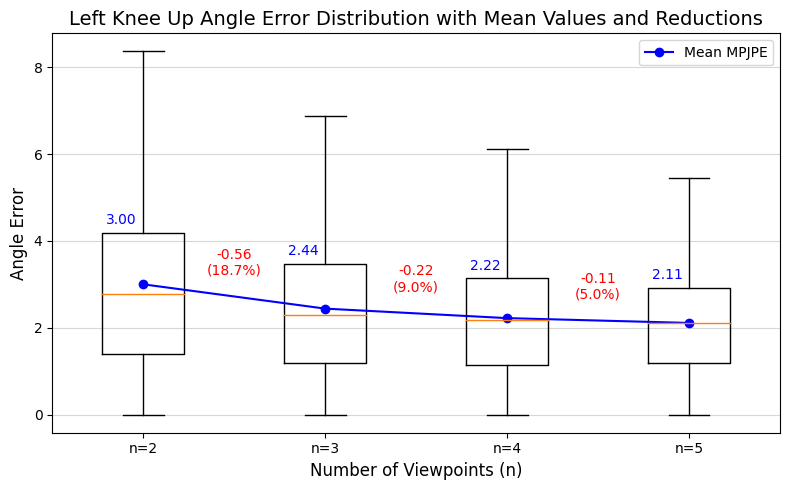

In [73]:
for angle, df in angle_dict.items():
    plt.figure(figsize=(8, 5))
    boxplot_data = []
    q3_values = []

    for n in range(2, 6):
        values = df[df["Combination"].str.len() == n]["Error Value"]
        boxplot_data.append(values)
        q3_values.append(values.quantile(0.75))

    plt.boxplot(boxplot_data, labels=[f"n={n}" for n in range(2, 6)], showfliers=False)

    plt.plot(range(1, 5), mean_values, marker='o', linestyle='-', color='blue', label="Mean MPJPE")

    for i, (start, end) in enumerate(zip(mean_values[:-1], mean_values[1:])):
        diff = start - end
        rate = diff / start * 100
        plt.text(i + 1.5, (start + end) / 2 + 0.5, f"-{diff:.2f}\n({rate:.1f}%)", ha='center', fontsize=10, color='red')

    for i, (mean, q3) in enumerate(zip(mean_values, q3_values)):
        plt.text(i + 0.88, q3 + 0.2, f"{mean:.2f}", ha='center', fontsize=10, color='blue')

    plt.title(f"{angle} Angle Error Distribution with Mean Values and Reductions", fontsize=14)
    plt.xlabel("Number of Viewpoints (n)", fontsize=12)
    plt.ylabel("Angle Error", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

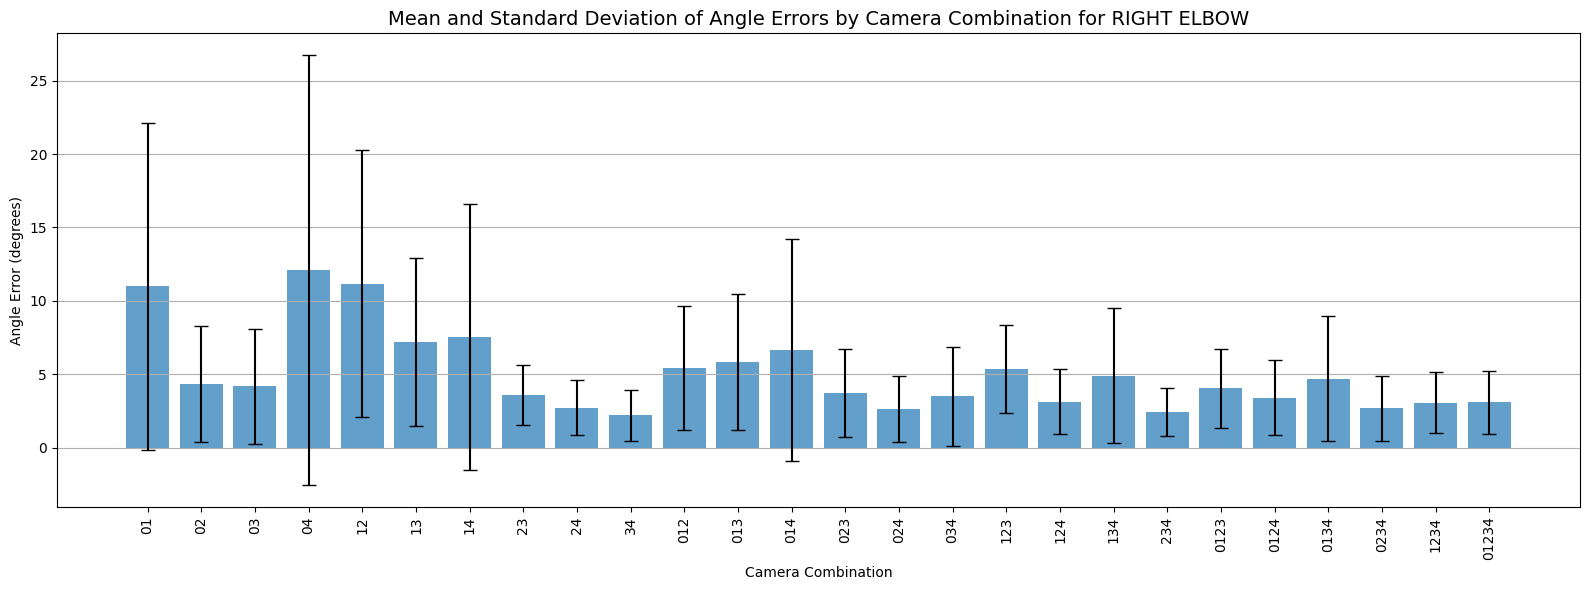

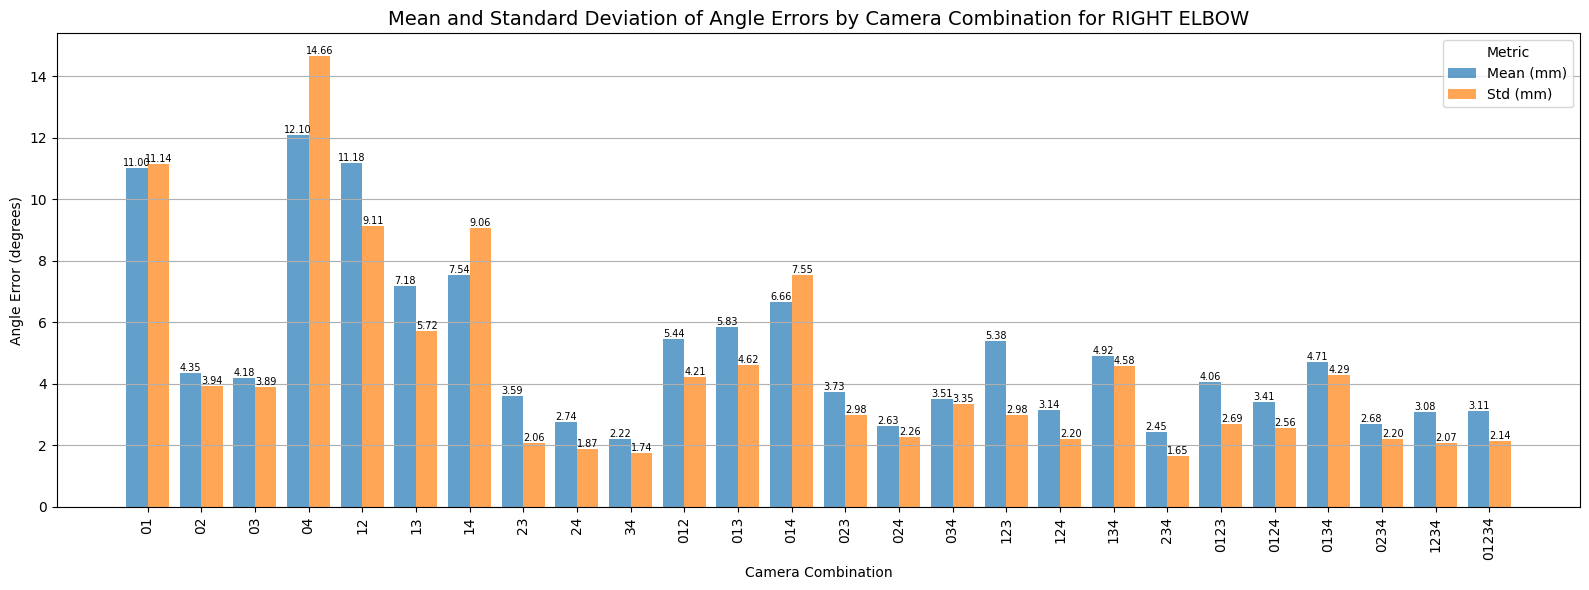

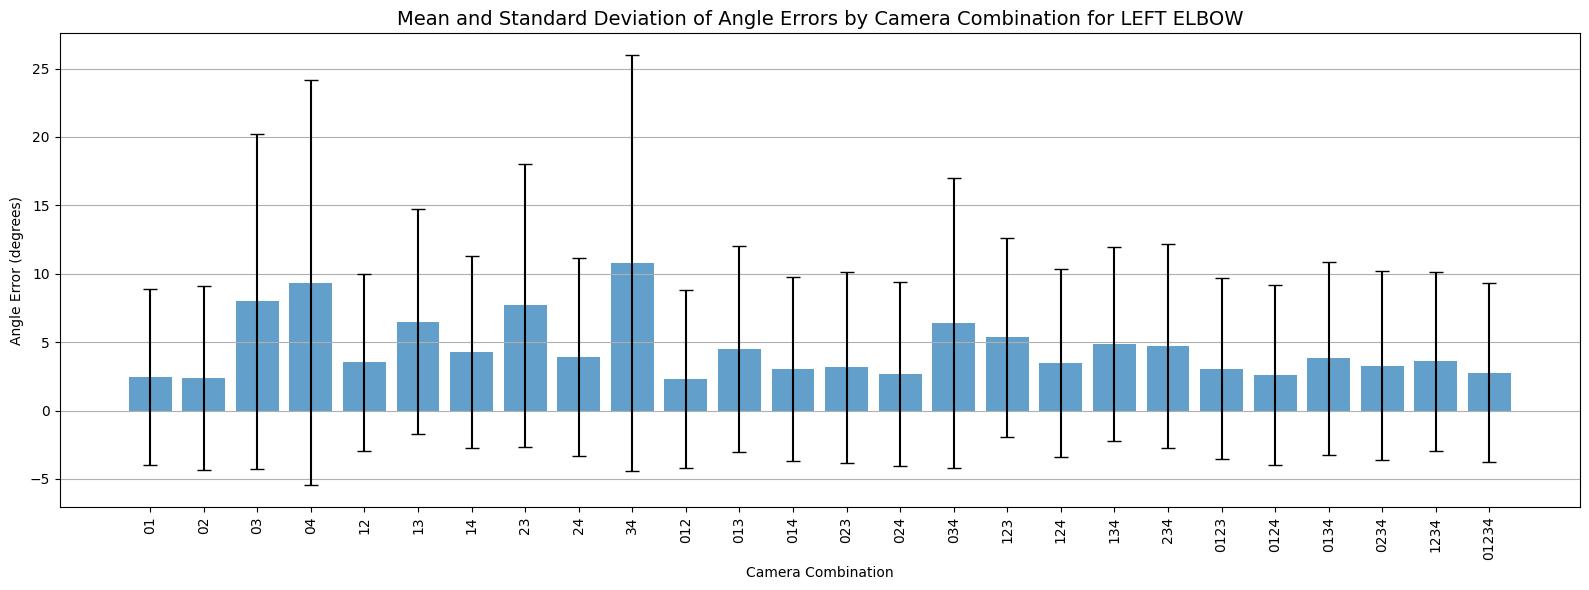

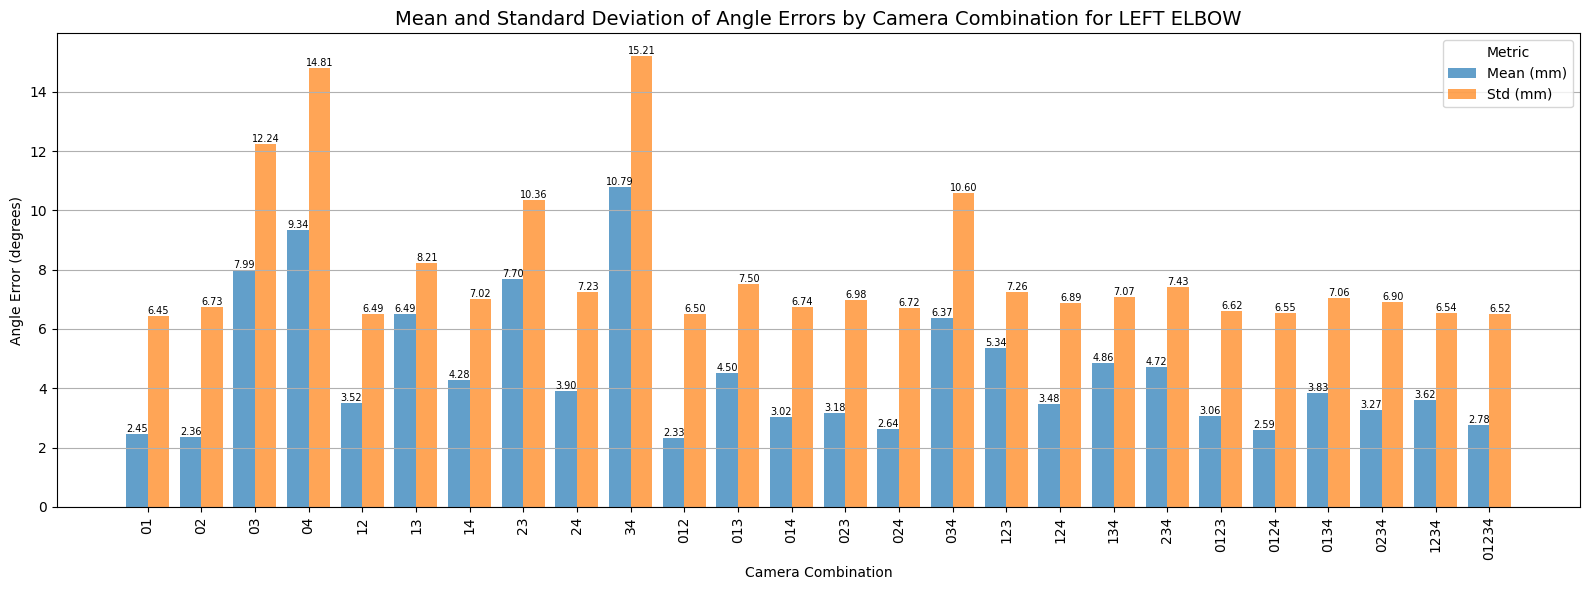

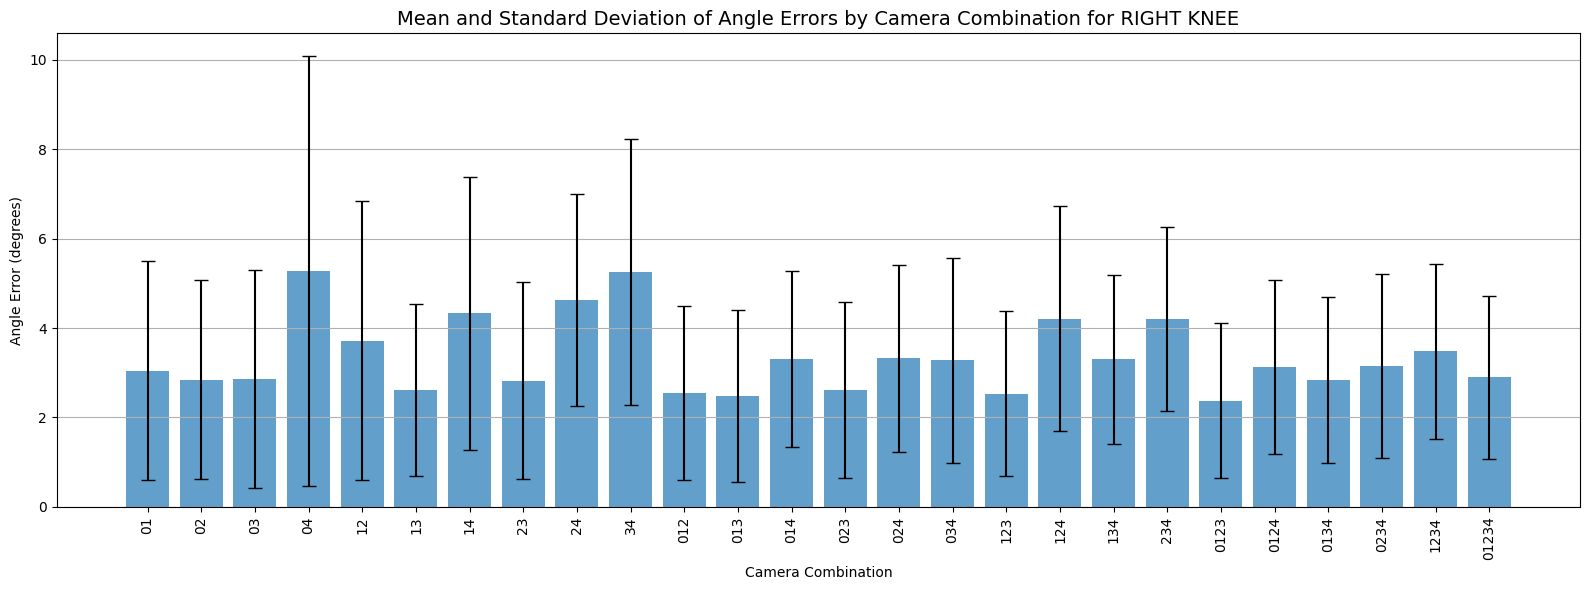

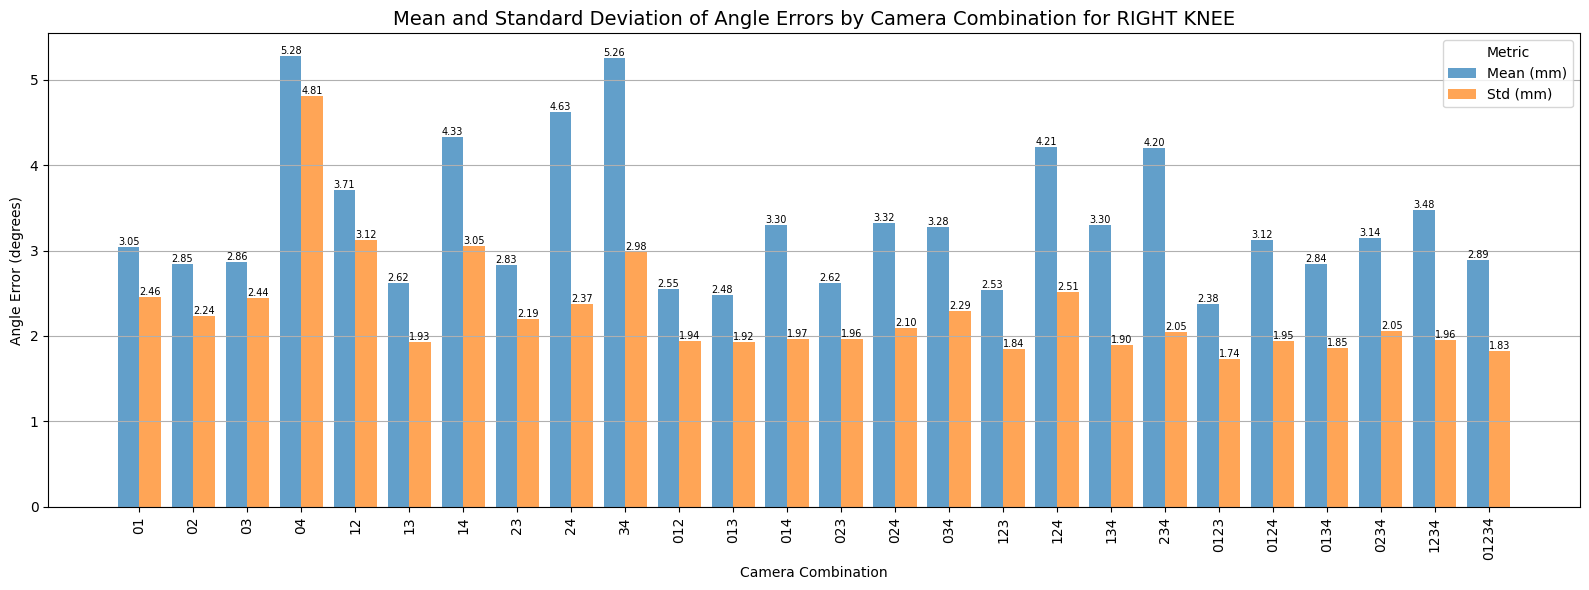

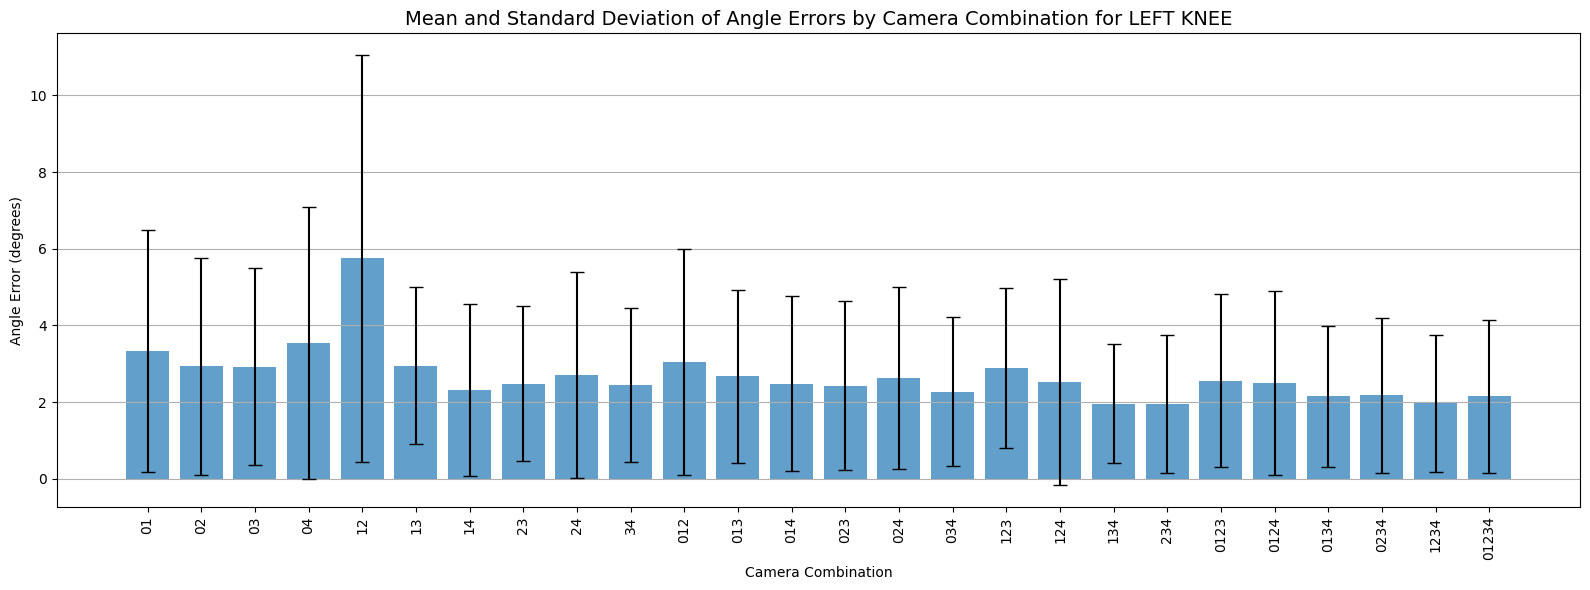

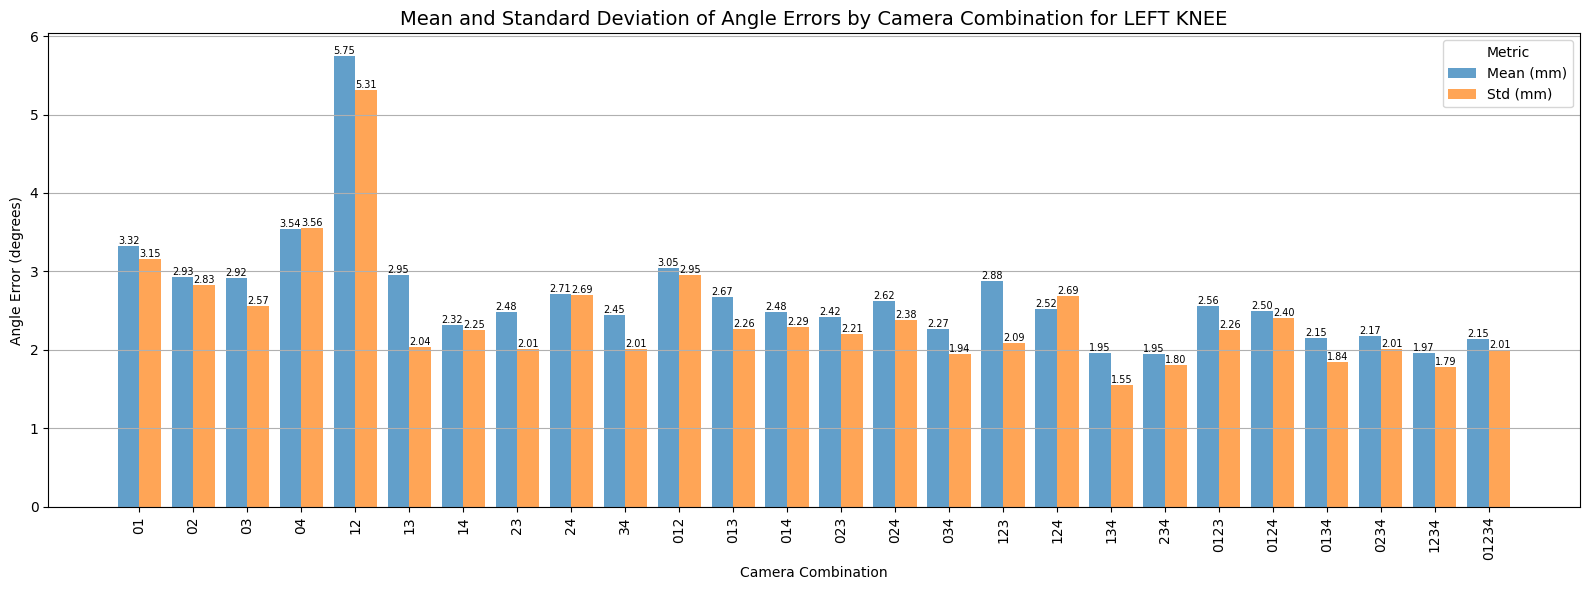

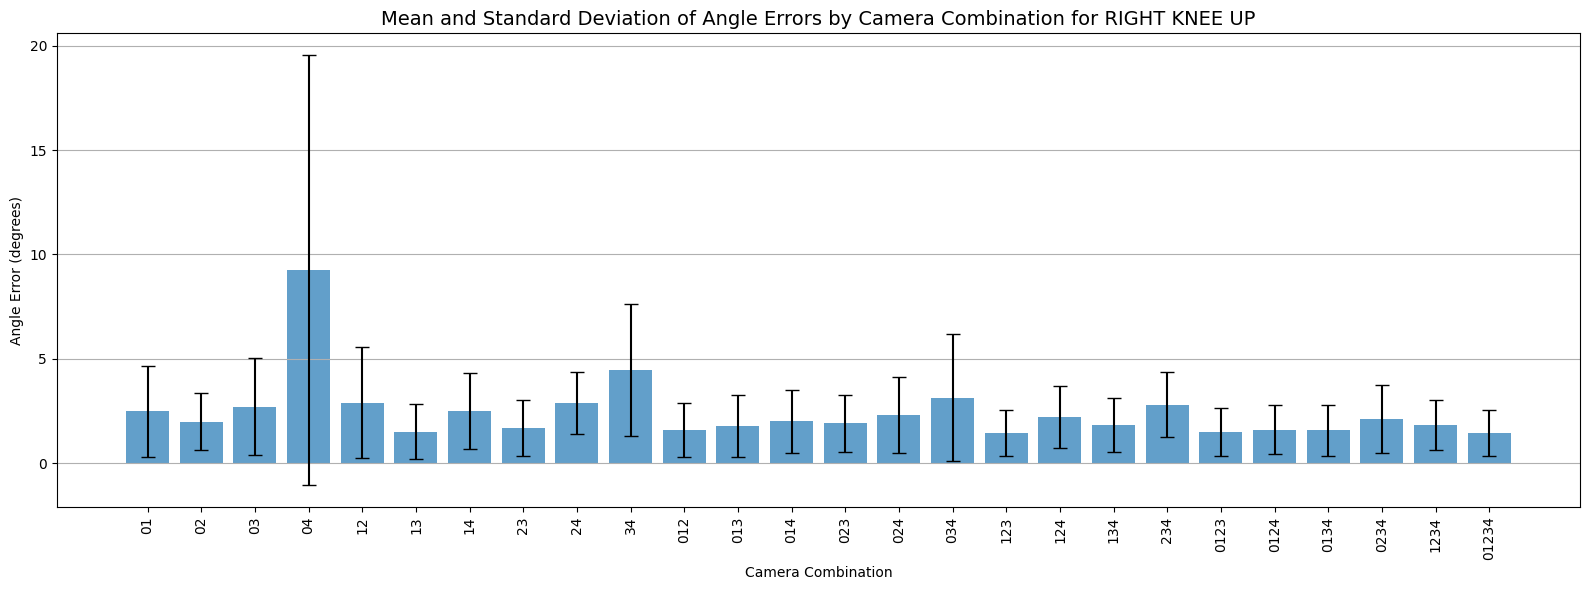

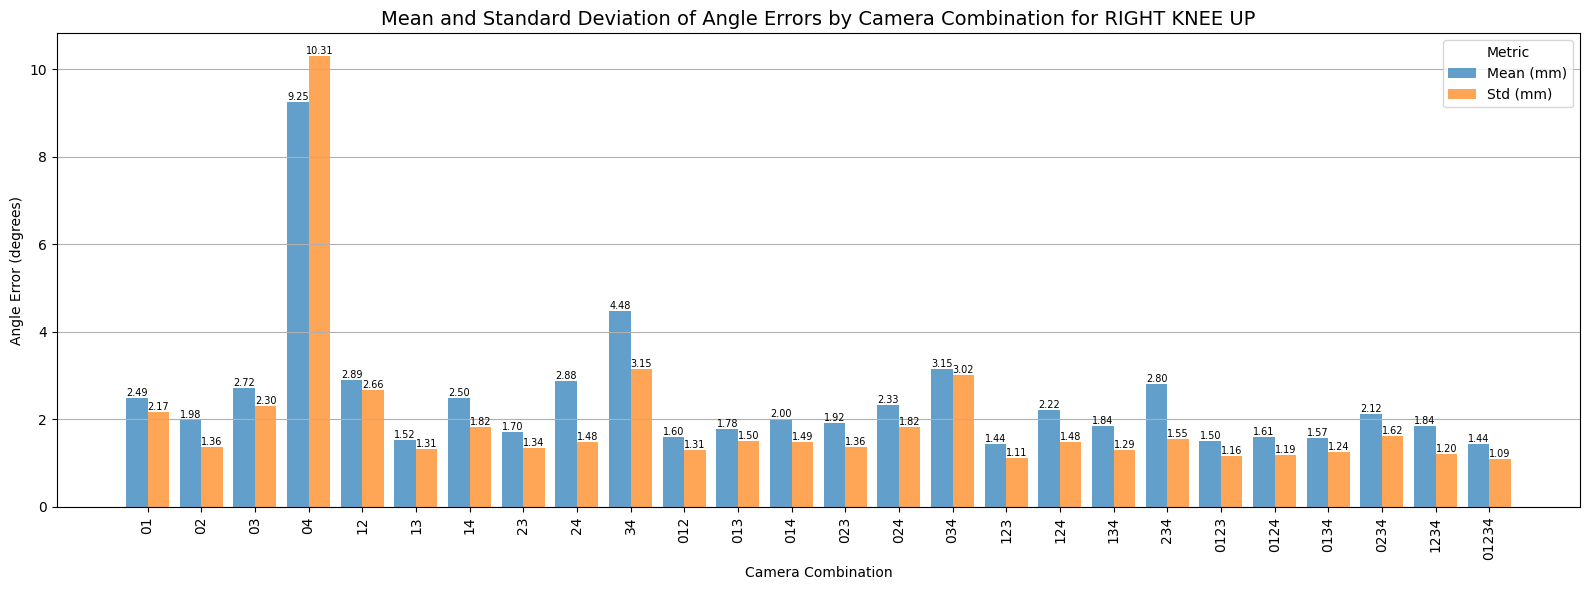

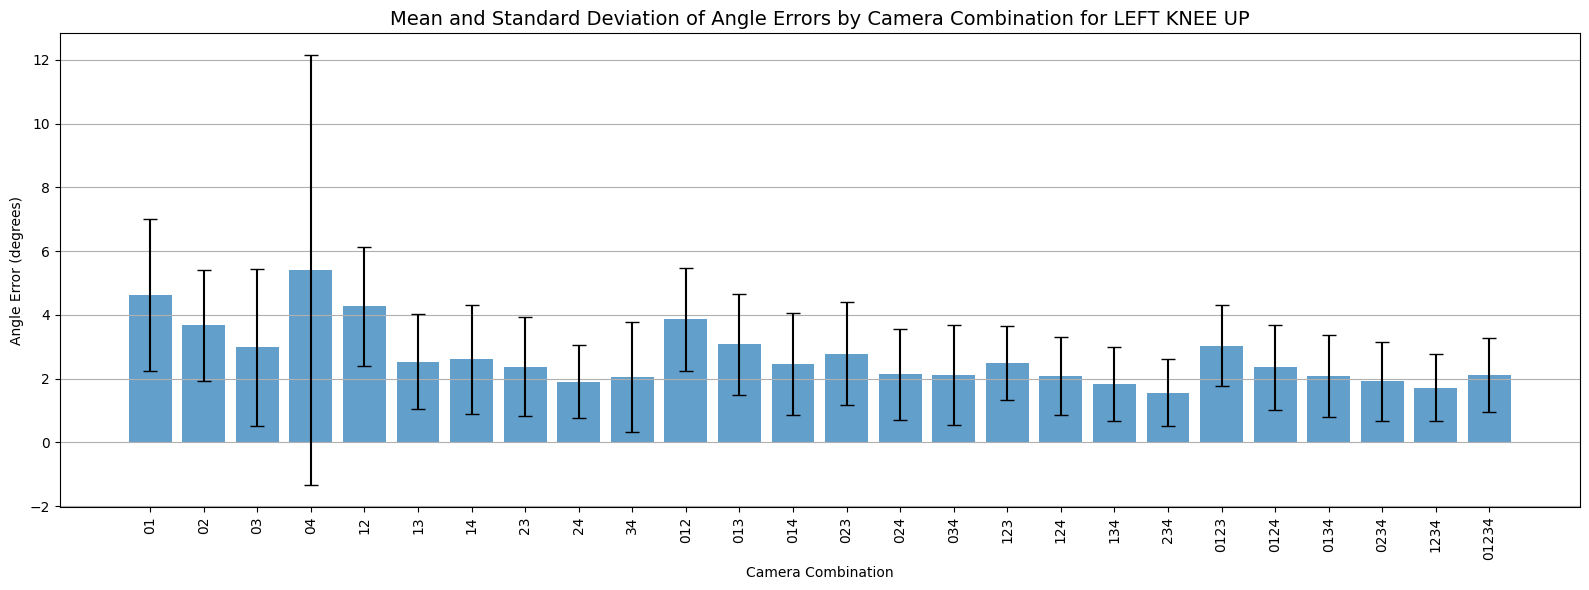

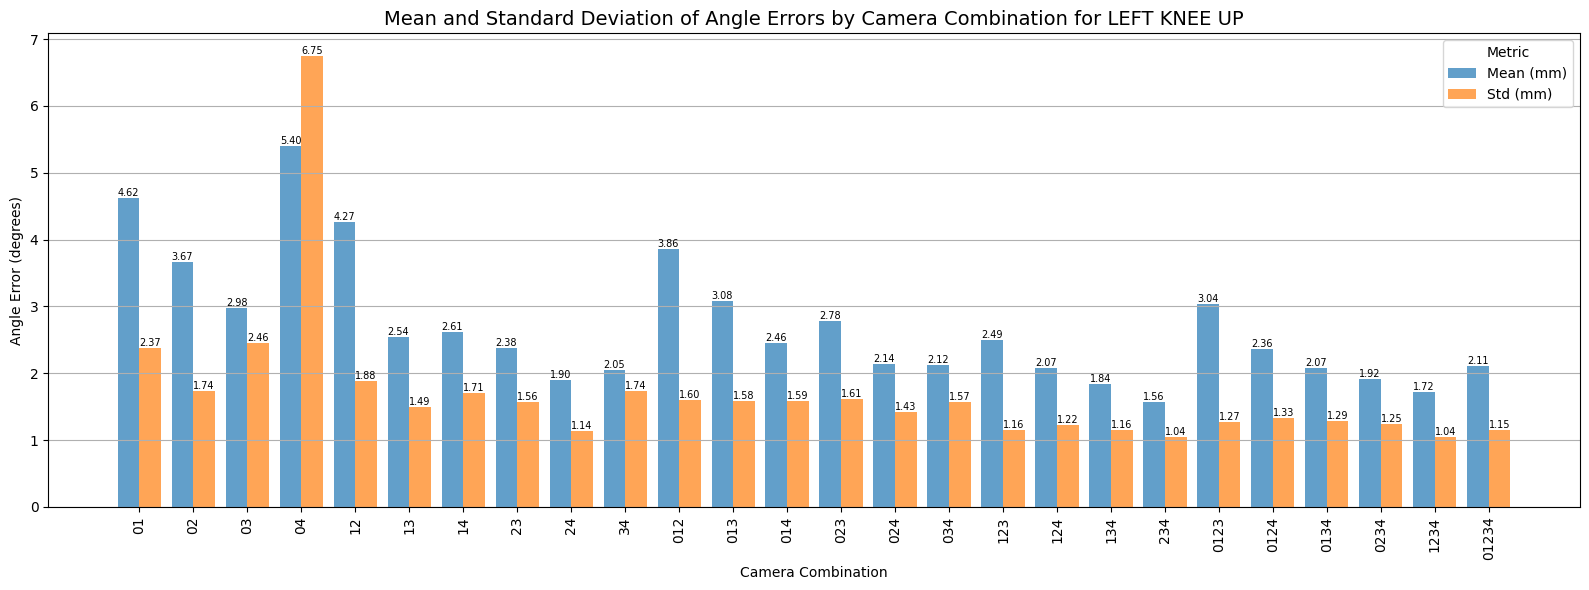

In [74]:
combination_order = raw_combination_df["Combination"].unique()

for angle in ["RIGHT ELBOW", "LEFT ELBOW", "RIGHT KNEE", "LEFT KNEE", "RIGHT KNEE UP", "LEFT KNEE UP"]:
    mean_values = raw_combination_df[raw_combination_df["Error Type"] == angle].groupby("Combination")["Error Value"].mean().reindex(combination_order)
    std_values = raw_combination_df[raw_combination_df["Error Type"] == angle].groupby("Combination")["Error Value"].std().reindex(combination_order)

    plt.figure(figsize=(16, 6))
    plt.bar(mean_values.index, mean_values, yerr=std_values, capsize=5, alpha=0.7)
    plt.xticks(rotation=90)
    plt.title("Mean and Standard Deviation of Angle Errors by Camera Combination for " + angle, fontsize=14)
    plt.xlabel("Camera Combination")
    plt.ylabel("Angle Error (degrees)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    x = range(len(mean_values))
    bar_width = 0.4

    plt.figure(figsize=(16, 6))
    mean_bars = plt.bar(x, mean_values, width=bar_width, label='Mean (mm)', alpha=0.7)
    std_bars = plt.bar([p + bar_width for p in x], std_values, width=bar_width, label='Std (mm)', alpha=0.7)

    for bar, mean in zip(mean_bars, mean_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mean:.2f}', ha='center', va='bottom', fontsize=7, color='black')
    for bar, std in zip(std_bars, std_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{std:.2f}', ha='center', va='bottom', fontsize=7, color='black')

    plt.xticks([p + bar_width / 2 for p in x], mean_values.index, rotation=90)
    plt.title("Mean and Standard Deviation of Angle Errors by Camera Combination for " + angle, fontsize=14)
    plt.xlabel("Camera Combination")
    plt.ylabel("Angle Error (degrees)")
    plt.legend(title="Metric")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()